<a href="https://colab.research.google.com/github/delffine/Pet-projects/blob/main/bike_train_duration/veloopros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вводная часть

Это исследование взаимосвязи функциональной мощности и длительности тренировок велосипедистов и триатлетов. Анализ проведен по данным опроса спортсменов, который проведился в телеграмм-канале [Тренер Сурен](https://t.me/surencoach/1082). Всего в опросе приняло участие более 250 спортсменов. Требовалось обнаружить и описать взаимосвязи объема тренировок с мощностью, а также возможные связи с другими параметрами ттренировок и спорстменов.

О качестве данных ничего неизвестно, но данные формы опроса могут содержать инормация в неудобном для анализа формате. Поэтому поребуется предобработка даннызх

Ход исследования:
- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Определение корреляции числовых показателей
- Определение взаимосвязи FTP и веломинут
- Когортный анализ данных по FTP, веломинутам и стажу
- Изучение волнового характера роста FTP с ростом веломинут
- Сравнение тренировок велосипедистов и триатлетов
- Сравнение способов определения FTP


# Процедуры и функции

В этом разделе размещены используемые в анализе процедуры и функции

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import math
import numpy as np
import scipy.stats as stats
from matplotlib.colors import TwoSlopeNorm

In [2]:
pd.options.display.max_colwidth = 9000

In [3]:
#Цвет RGB в HEX
def rgba2hex(rgba):
    r = int(rgba[0] * 255)
    g = int(rgba[1] * 255)
    b = int(rgba[2] * 255)
    return f'#{r:02x}{g:02x}{b:02x}'


In [4]:
#Список градиентов цвета в зависимости от входной величины
def gradient_by_value(col = pd.Series([]), gradient = plt.cm.RdYlGn_r):
    norm = TwoSlopeNorm(vmin=col.min(), vcenter=col.mean(), vmax=col.max())
    colors = [rgba2hex(gradient(norm(c))) for c in col]
    return colors

In [5]:
# Вывод проверки выброк для тестирования
def chek_dd_test(d_test1, d_test2):
  norm1 = False
  norm2 = False
  pval = stats.normaltest(d_test1)[1]
  if pval < 0.05:
     print(f'Первая выборка размером {len(d_test1)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
  else:
      print(f'Первая выборка размером {len(d_test1)} прошла проверку на нормальное распределение. pval = {pval}')
      norm1 = True

  pval = stats.normaltest(d_test2)[1]
  if pval < 0.05:
      print(f'Вторая выборка размером {len(d_test2)} НЕ прошла проверку на нормальное распределение. pval = {pval}')
  else:
      print(f'Вторая выборка размером {len(d_test2)} прошла проверку на нормальное распределение. pval = {pval}')
      norm2 = True

  equal_var = False
  pval = stats.levene(d_test1, d_test2)[1]
  if pval < 0.05:
      print(f'Дисперсии выборок НЕ близки. pval = {pval}. Применяем equal_var=False')
  else:
      print(f'Дисперсии выборок близки. pval = {pval}. Применяем equal_var=True ')
      equal_var = True
  return norm1, norm2, equal_var

In [6]:
# Вывод результатов тестирования в зависимост от pvalue
def pval_print (pval, h0='', h1=''):
    print('В результате теста получено p-value', pval)
    if pval < 0.05:
        print('НЕ можем принять нулевую гипотезу, принимаем альтернативную:')
        print(' ------> \033[31m\033[1m', h1, '\033[0m')
    else:
        print('НЕ можем отвегнуть нулевую гипотезу, принимаем ее:')
        print(' ------> \033[32m\033[1m', h0, '\033[0m')

In [7]:
# Тестирование сравнения двух выборок
def test_selection (d_test1, d_test2, side='two-sided', h0='', h1=''):
  norm1, norm2, e_var = chek_dd_test(d_test1, d_test2)
  l1 = (len(d_test1) >= 30)
  l2 = (len(d_test2) >= 30)
  print()
  if (norm1 & norm2): print('Обе выборки имеют нормальное распределение!')
  if ((l1 or norm1) and (l2 or norm2)) :
    if (l1 & l2): print(f'Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest')
    print()
    print('--- Проводим TTest ---')
    pval = stats.ttest_ind(d_test1, d_test2, alternative = side, equal_var=e_var)[1]
    pval_print(pval, h0, h1)
    print()
    print('Для сравнения проведем и параметрический тест Манна-Уитни')
    print()
  else:
    print(f'Выборки маленькие ({len(d_test1)} / {len(d_test2)}) - НЕЛЬЗЯ применять ttest')

  print('---- Проводим Test Mann-Whitneyu ----')
  pval = stats.mannwhitneyu(d_test1, d_test2, alternative = side)[1]
  pval_print(pval, h0, h1)

In [8]:
#подсветка ячеек, значения которых меньше 0.05
def highlight_stat(s, color='orange', p = 0.05):
    return ['background-color: '+color if val < p  else 'background-color: none' for val in s]

In [9]:
#подсветка ячеек, значения которых меньше 0.05
def highlight_over(s, color='lime', p = 0.5):
    return ['background-color: '+color if val > p  else 'background-color: none' for val in s]

# Загрузка данных

Данные для аналза хранятся в excel файле на google.disc

In [10]:
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/dtp/'):
  from google.colab import drive
  drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/bike_duration/

/content/drive/My Drive/Colab Notebooks/bike_duration


In [11]:
data = pd.read_excel('bike_train_duration.xlsx')

In [12]:
data.head()

,Timestamp,Ваш вес,Ваш пол,Ваш вид спорта,"Какой у вас средний тренировочный объем велотренировок в неделю в часах за последний год (укажите, пожалуйста, в формате чч:мм:сс)","Если знаете, то укажите какой у вас средний тренировочный объем в неделю в часах за последний год по другим активности вместе взятым (силовые, бег, плавание и тд, в формате чч:мм:сс)",Сколько месяцев или лет (уточните в ответе) у вас общий тренировочный стаж в тренировках по велосипеду? Если был значительный перерыв в тренировках также напишите про это.,"Какой у вас наивысший уровень анаэробного порога (часовой мощности или ФТП) в этом сезоне? Укажите цифру по мощности (например, 210)",Каким способом вы определили ваш пиковый анаэробный порог (ФТП) в сезоне?,Стаж ручное редактировние
0,2024-12-26 12:58:01.835,73.0,Мужской,Триатлон,6:00:00,11:00:00,4 года,285,По результатом полевых тестирований,48
1,2024-12-26 12:59:07.121,73.0,Мужской,Велоспорт,13:16:25,NaN,4,320,Расчетным путем исходя их результатов гонок,48
2,2024-12-26 13:00:24.132,73.0,Мужской,Триатлон,05:43:57,10:49:50,5 лет,215,Из результатов лабораторного тестирования,60
3,2024-12-26 13:00:38.202,82.0,Мужской,Триатлон,4:30:00,8:30:00,2года,215,Seift,24
4,2024-12-26 13:01:04.913,77.0,Мужской,Трейл,00:44:29,NaN,"Где то с прошлого лета крутил когда купил вело тренажер , кручу переиодически не постоянно",257,По результатом полевых тестирований,18


Переименовываем колонки

In [13]:
data.columns = ('date_answer' , 'weigth', 'gender', 'sport', 'bike_hours', 'train_hours', 'train_stag', 'ftp', 'ftp_source', 'stag_r')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_answer  252 non-null    datetime64[ns]
 1   weigth       252 non-null    float64       
 2   gender       252 non-null    object        
 3   sport        252 non-null    object        
 4   bike_hours   252 non-null    object        
 5   train_hours  181 non-null    object        
 6   train_stag   252 non-null    object        
 7   ftp          252 non-null    int64         
 8   ftp_source   252 non-null    object        
 9   stag_r       252 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 19.8+ KB


# Предобработка данных

Преобразуем исходные данные к удобоваримому виду

In [15]:
for i in range(0, len(data)):
# ------------- велотренировки ---------------------------
    bh = str(data.loc[i, 'bike_hours'])
    if bh != bh: bh = '0'
    bh = bh.replace(',', '.')
    bh = bh.replace('-', ':')
    bh = re.sub(r'[^0-9.:]+', '', bh)
    digits = []
    digits.append(re.split(':', bh))
    try:
        minuts = float(digits[-1][0]) * 60 + float(digits[-1][1])
    except:
        try:
            minuts = float(digits[-1][0]) * 60
        except:
            minuts = 0
    data.loc[i, 'bike_minute'] = minuts

# -------------- остальные тренировки -----------------------------
    th = str(data.loc[i, 'train_hours'])
    if th != th: th = '0'
    th = th.replace(',', '.')
    th = th.replace('-', ':')
    th = re.sub(r'[^0-9.:]+', '', th)
    digits = []
    digits.append(re.split(':', th))
    try:
        minuts = float(digits[-1][0]) * 60 + float(digits[-1][1])
    except:
        try:
            minuts = float(digits[-1][0]) * 60
        except:
            minuts = 0
    data.loc[i, 'train_minute'] = minuts

# ------------ Стаж. Каша в данных ---------------------
#    st = str(data.loc[i, 'train_stag'])
#    if st != st: st = '0'
#
#    st = re.sub(r'[^0-9.:]+', '', st)
#    try:
#        stag = float(st)
#    except:
#        stag = 0
#    data.loc[i, 'stag_c'] = stag
#
# ------------ вес ----------------------------------
    wg = str(data.loc[i, 'weigth'])
    if wg != wg: wg = '0'
    wg = wg.replace(',', '.')
    wg = re.sub(r'[^0-9.:]+', '', wg)
    try:
        weigth = float(wg)
    except:
        weigth = 0
    data.loc[i, 'weigth_c'] = weigth


# ----------- FTP  ---------------------------------
    ftp = str(data.loc[i, 'ftp'])
    if ftp != ftp: ftp = '0'

    ftp = re.sub(r'[^0-9.:]+', '', ftp)
    try:
        ftpf = float(ftp)
    except:
        ftpf = 0
    data.loc[i, 'ftp_c'] = ftpf


Проверяем аномалии по колонкам

Все аномалии правятся вручную в файла данных на гугл диске !!!!

аномальный вес

In [16]:
data.query('weigth_c < 50 | weigth_c > 150')

,date_answer,weigth,gender,sport,bike_hours,train_hours,train_stag,ftp,ftp_source,stag_r,bike_minute,train_minute,weigth_c,ftp_c


аномальный FTP

In [17]:
data.query('ftp_c < 100 | ftp_c > 500')[['date_answer', 'gender', 'sport', 'ftp', 'ftp_c']]

,date_answer,gender,sport,ftp,ftp_c


аномальные веломинуты

*Здесь и далее, если речь идет о только о велотренировках, то используется термин "веломинуты"*


In [18]:
data.query('bike_minute < 30 | bike_minute > 1000')[['date_answer', 'gender', 'sport', 'bike_hours', 'bike_minute', 'ftp_c']]

,date_answer,gender,sport,bike_hours,bike_minute,ftp_c
154,2024-12-28 08:52:36.671,Мужской,Велоспорт,19:54:06,1194.0,323.0
187,2024-12-29 08:58:49.609,Мужской,"Бег, лыжи",00:25:29,25.0,260.0
232,2024-12-29 11:37:34.693,Мужской,Триатлон,17:45:00,1065.0,360.0


Аномальная длительность других тренировок

In [19]:
data.query('(train_minute > 0 & train_minute < 30) | train_minute > 1000')[['date_answer', 'gender', 'sport', 'train_hours', 'train_minute']]

,date_answer,gender,sport,train_hours,train_minute
123,2024-12-26 22:08:12.788,Мужской,Велоспорт,00:13:30,13.0
138,2024-12-27 09:14:37.500,Мужской,Велоспорт,00:15:00,15.0


Переназначаем индексы после предоботки

In [20]:
data = data.reset_index(drop = True)

In [21]:
len(data)

252

In [22]:
#Расчет FTP в ватт/кг
data['ftp_weigth'] = data['ftp_c'] / data['weigth_c']

**Промежуточные итоги**

Предобработка исходных данных включала:
Очистку числовых данных от буквенных символов и перевод веломинут и длительности остальных тренировок, указанные в основном в формате ЧЧ:ММ:СС, в минуты.
После программного преобразования выполнена проверка на аномалии и вручную исправлено несколько некорректных значений. Удалено три строчки.

# Исследовательский анализ данных

## Категориальные данные

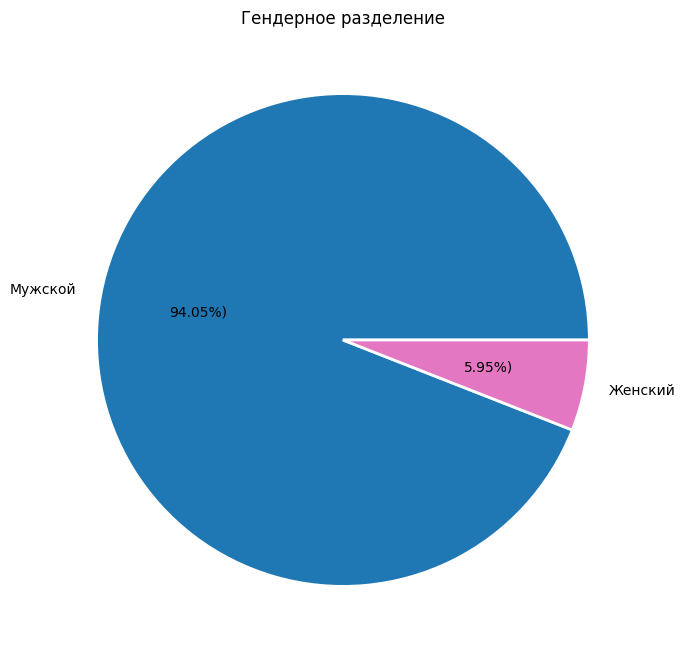

In [23]:
dd = data['gender'].value_counts()

fig = plt.figure(figsize = (15, 8))
plt.pie(x = dd, labels = dd.index, colors = ['tab:blue', 'tab:pink', 'yellow'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Гендерное разделение')
plt.show()

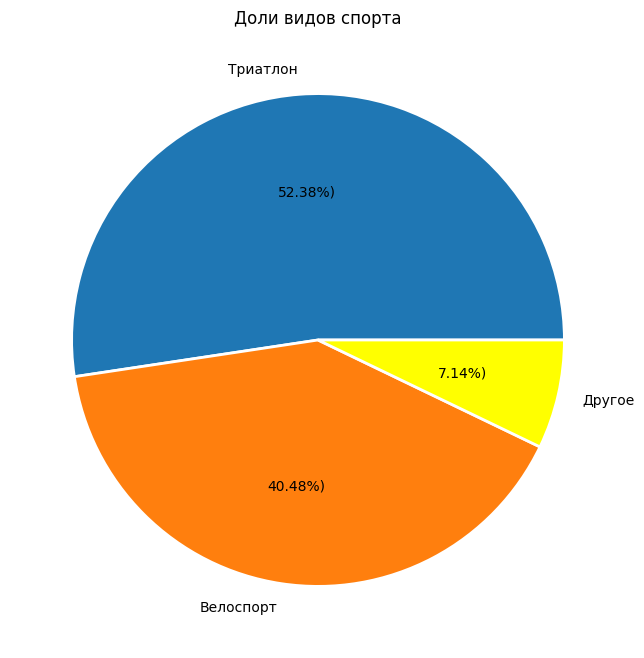

In [24]:
dd = data['sport'].apply(lambda x: 'Другое' if x not in ('Триатлон', 'Велоспорт') else x).value_counts()

fig = plt.figure(figsize = (15, 8))
plt.pie(x = dd, labels = dd.index, colors = ['tab:blue', 'tab:orange', 'yellow'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Доли видов спорта')
plt.show()



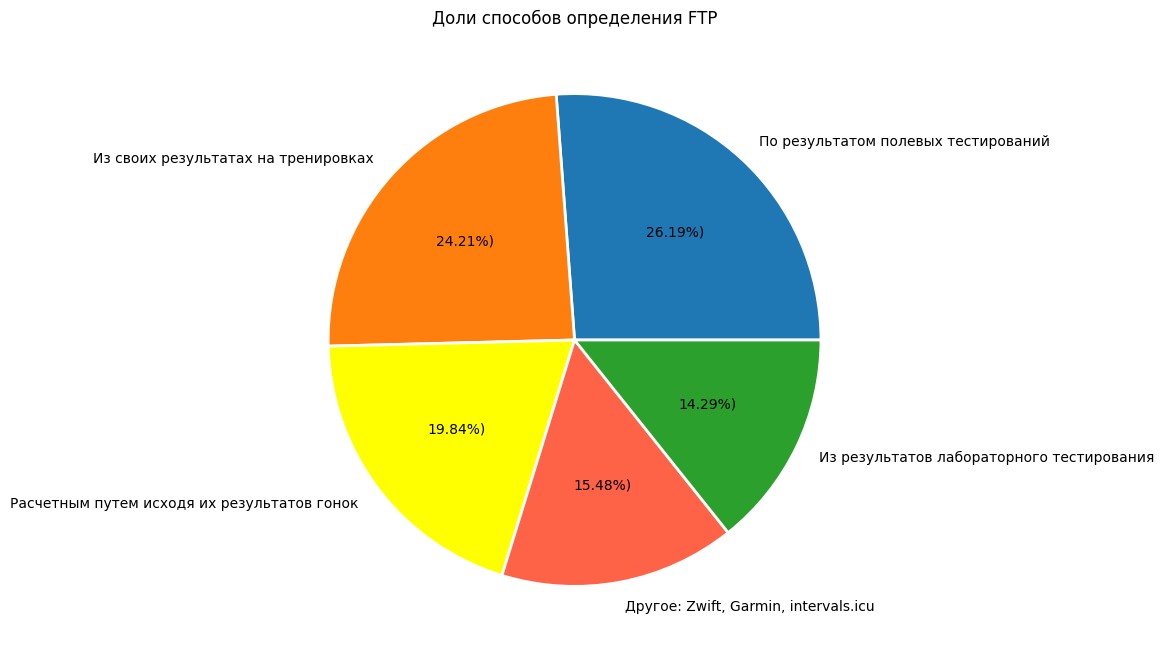

In [25]:
data['ftp_source_c'] = data['ftp_source'].apply(lambda x: 'Другое: Zwift, Garmin, intervals.icu' if x not in (
    'По результатом полевых тестирований',
    'Из своих результатах на тренировках',
    'Расчетным путем исходя их результатов гонок',
    'Из результатов лабораторного тестирования',
    ) else x)

fig = plt.figure(figsize = (15, 8))
plt.pie(x = data['ftp_source_c'].value_counts(), labels = data['ftp_source_c'].value_counts().index, colors = ['tab:blue', 'tab:orange', 'yellow', 'tomato', 'tab:green'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
plt.title('Доли способов определения FTP')
plt.show()

Стаж можно также считать категориальной функцией

## Статистические харакретистики числовых показателей

In [26]:
train_stat = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
train_stat.loc['Вело тренировки'] = data['bike_minute'].describe()
train_stat.loc['Другие тренировки'] = data['train_minute'].describe()
train_stat.loc['FTP'] = data['ftp_c'].describe()
train_stat.loc['Вес'] = data['weigth_c'].describe()
train_stat.loc['Стаж'] = data['stag_r'].describe()
train_stat

,count,mean,std,min,25%,50%,75%,max
Вело тренировки,252.0,322.469048,196.858995,25.0,180.0,276.5,414.0,1194.0
Другие тренировки,252.0,239.091270,236.218237,0.0,0.0,210.0,391.0,960.0
FTP,252.0,257.658730,47.555070,139.0,222.0,252.5,290.0,402.0
Вес,252.0,75.443651,10.313075,52.0,69.0,75.5,81.0,122.0
Стаж,252.0,51.753968,42.880207,2.0,24.0,40.0,60.0,360.0


Расшифровка
- count - количество спортсменов, по которому расчитаны характеристики
- mean - среднее
- std - стандартное отклонение
- min - минимальное значение
- 25% - первый квантиль - граница 25% значений
- 50% - медиана
- 75% - третий квантиль - граница 75% значений
- max - максимальное значение

Читается так: среднее значение FTP - 261, медианное - 260, минимальное - 158, максимальное - 402. Серединная половина спорстменов имеет FTP от 227 до 293 ватт - такая широкая "золотая середина".

Те же статистические характеристики на графике "ящик с усами"

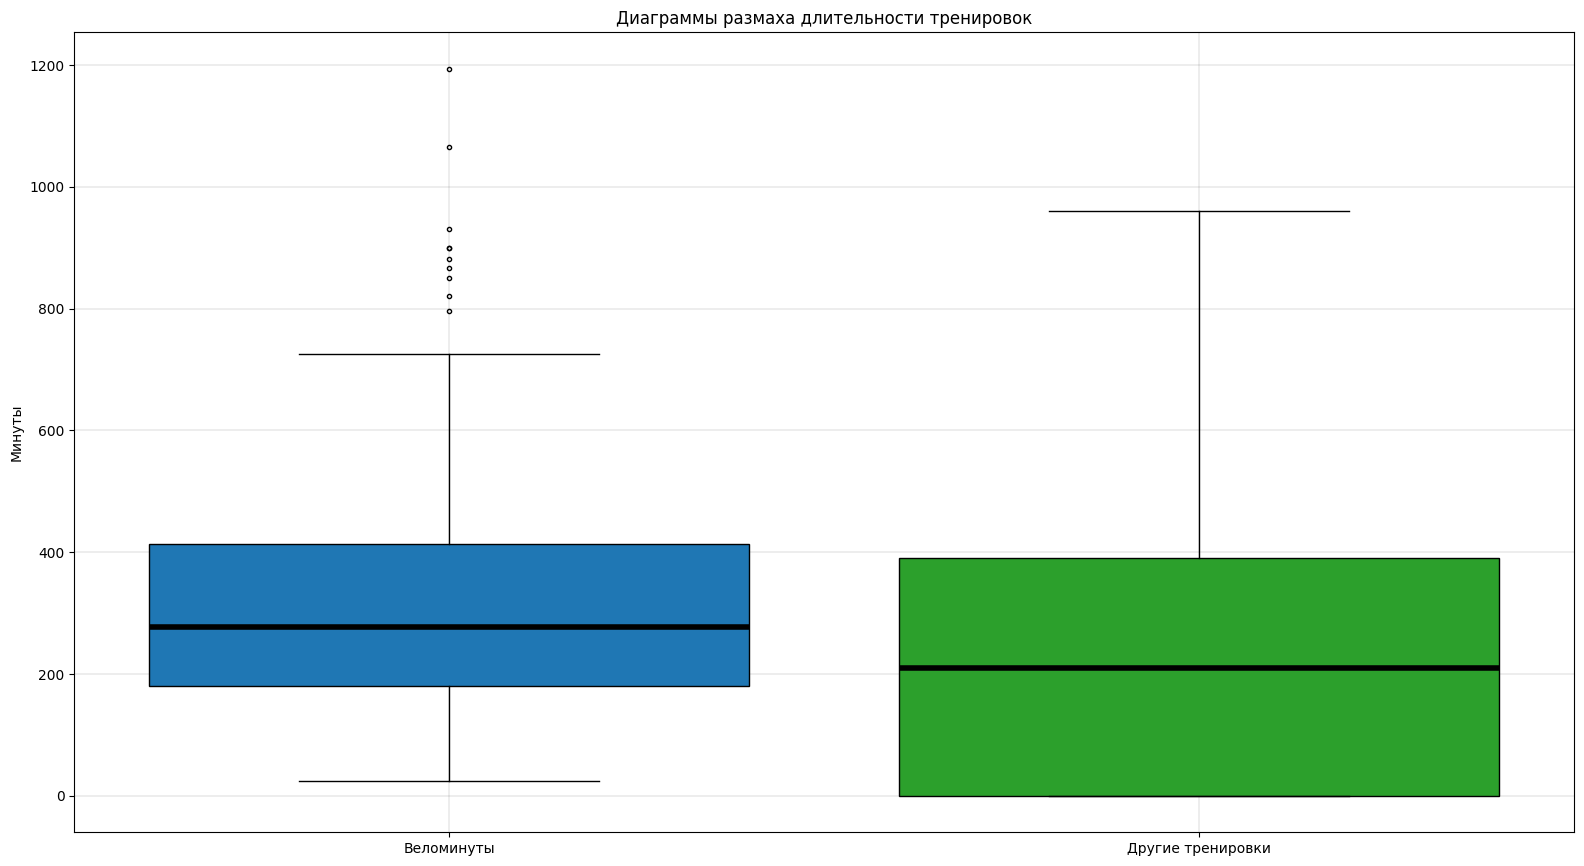

In [27]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(data['bike_minute'], positions=[0], labels = ['Веломинуты'], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:blue'), medianprops=dict(color='black', linewidth=4))
ax.boxplot(data['train_minute'], positions=[1], labels = ['Другие тренировки'], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:green'), medianprops=dict(color='black', linewidth=4))

plt.title('Диаграммы размаха длительности тренировок')
plt.xlabel('')
plt.ylabel('Минуты')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

Закрашенная область - серединная половина, широкая "золотая середина". Толстая  черта в этой области - медиана. Кстати, она необязательно посередине закрашенной области. Верхний ус - граница в 97% спортсменов, нижний ус - 3%. Точки выше или ниже усов считаются "выбросами/аномалиями" и обычно из данных для дальнейшего анализа удаляются.

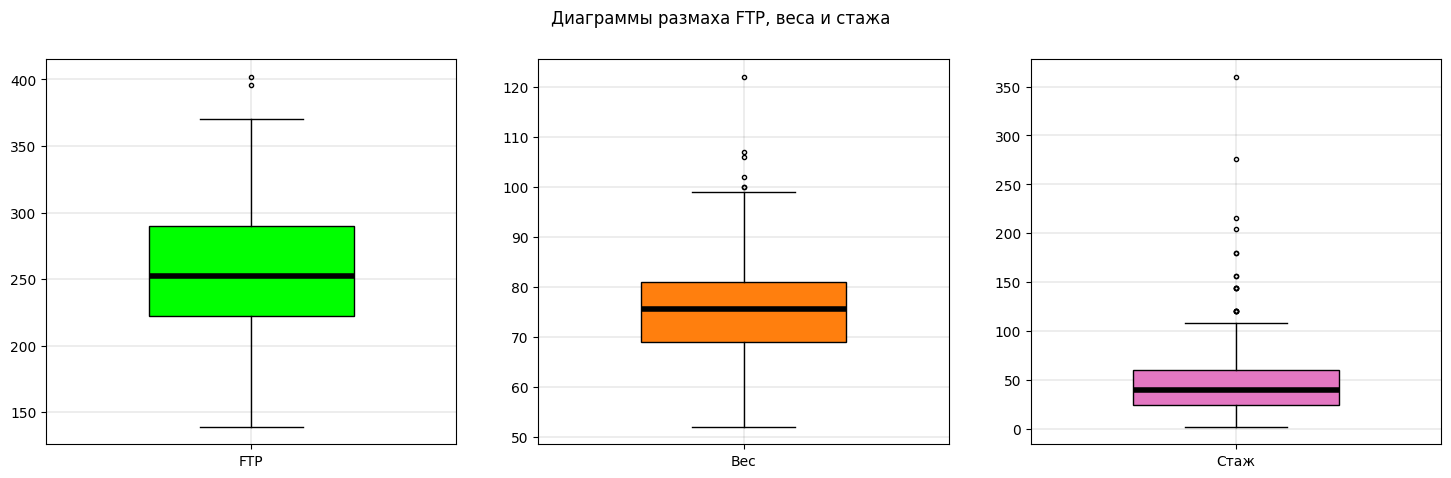

In [28]:
f, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].boxplot(data['ftp_c'], positions=[2], labels = ['FTP'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='lime'), medianprops=dict(color='black', linewidth=4))
ax[0].grid(color='black', linestyle='-', linewidth=0.1)

ax[1].boxplot(data['weigth_c'], positions=[2], labels = ['Вес'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:orange'), medianprops=dict(color='black', linewidth=4))

ax[1].grid(color='black', linestyle='-', linewidth=0.1)

ax[2].boxplot(data['stag_r'], positions=[2], labels = ['Стаж'], widths = 0.5 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor='tab:pink'), medianprops=dict(color='black', linewidth=4))
ax[2].grid(color='black', linestyle='-', linewidth=0.1)

plt.suptitle('Диаграммы размаха FTP, веса и стажа')
plt.show()


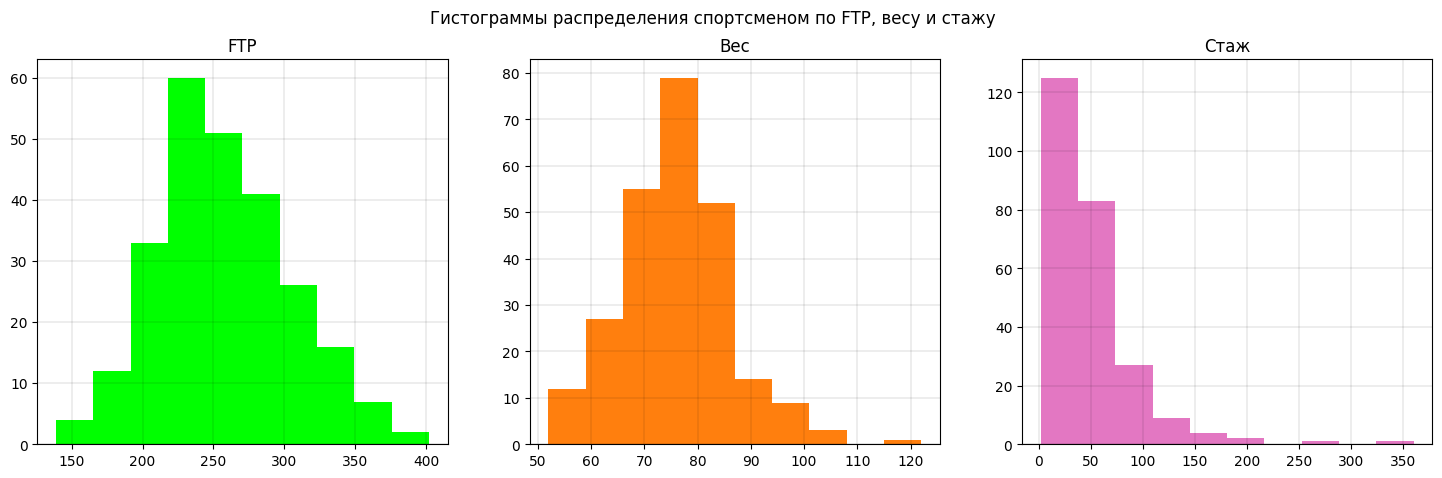

In [29]:
f, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].hist(data['ftp_c'], bins = 10, alpha = 1, color = 'lime')
ax[0].grid(color='black', linestyle='-', linewidth=0.1)
ax[0].set_title('FTP')

ax[1].hist(data['weigth_c'], bins = 10, alpha = 1, color = 'tab:orange')
ax[1].grid(color='black', linestyle='-', linewidth=0.1)
ax[1].set_title('Вес')

ax[2].hist(data['stag_r'], bins = 10, alpha = 1, color = 'tab:pink')
ax[2].grid(color='black', linestyle='-', linewidth=0.1)
ax[2].set_title('Стаж')

plt.suptitle('Гистограммы распределения спортсменом по FTP, весу и стажу')
plt.show()

## Аномалии и выбросы

Зададим верхнюю границу для аномальных значений в 97%

In [30]:
ftp_lim = data['ftp_c'].quantile(0.97)
bike_minute_lim = data['bike_minute'].quantile(0.97)
stag_minute_lim = data['stag_r'].quantile(0.97)

print(f'Верхняя граница нормальных значений FTP {ftp_lim}')
print(f'Верхняя граница нормальных значений веломинут {bike_minute_lim}')
print(f'Верхняя граница нормальных значений стажа {stag_minute_lim}')

Верхняя граница нормальных значений FTP 354.7
Верхняя граница нормальных значений веломинут 834.0999999999999
Верхняя граница нормальных значений стажа 149.64


Для дальнейшего анализа отбрасываем аномальные значения, выбросы

- FTP более 340
- веломинуты - более 800
- стаж - более 150 месяцев

In [31]:
data = data.query('ftp_c <= @ftp_lim & stag_r <= @stag_minute_lim & bike_minute <= @bike_minute_lim')

In [32]:
print(f'Дальнейший анализ пройдет на выборке из {len(data)} спорстменов')

Дальнейший анализ пройдет на выборке из 232 спорстменов


In [33]:
data = data.reset_index(drop = True)

# Корреляция FTP, тренировочных минут и веса

Шкала Чеддока для оценки корреляции:

- От 0 до 0,3 — очень слабая
- От 0,3 до 0,5 — слабая
- От 0,5 до 0,7 — средняя
- От 0,7 до 0,9 — сильная (высокая)
- От 0,9 до 1,0 — очень сильная (очень высокая)

Корреляция времени вело тренировок, FTP в ваттах, веса и FTP в ватт/кг методом Пирсена. Зеленым подсвечивается средняя корреляция и выше

In [34]:
data[['bike_minute', 'ftp_c', 'weigth_c', 'ftp_weigth', 'stag_r']].corr(method='pearson').style.apply(highlight_over, color='lime', p=0.5)

,bike_minute,ftp_c,weigth_c,ftp_weigth,stag_r
bike_minute,1.000000,0.407257,-0.192699,0.537685,0.235256
ftp_c,0.407257,1.000000,0.316913,0.682926,0.195447
weigth_c,-0.192699,0.316913,1.000000,-0.459882,-0.133259
ftp_weigth,0.537685,0.682926,-0.459882,1.000000,0.291866
stag_r,0.235256,0.195447,-0.133259,0.291866,1.000000


Между FTP и веломинутами обнаруживается средняя положительная корреляция. Причем в ваттах на килограмм связь сильнее.
Стаж с другими параметрами проявляет очень слабую корреляцию

# Диаграммы рассеяния FTP и веломинут


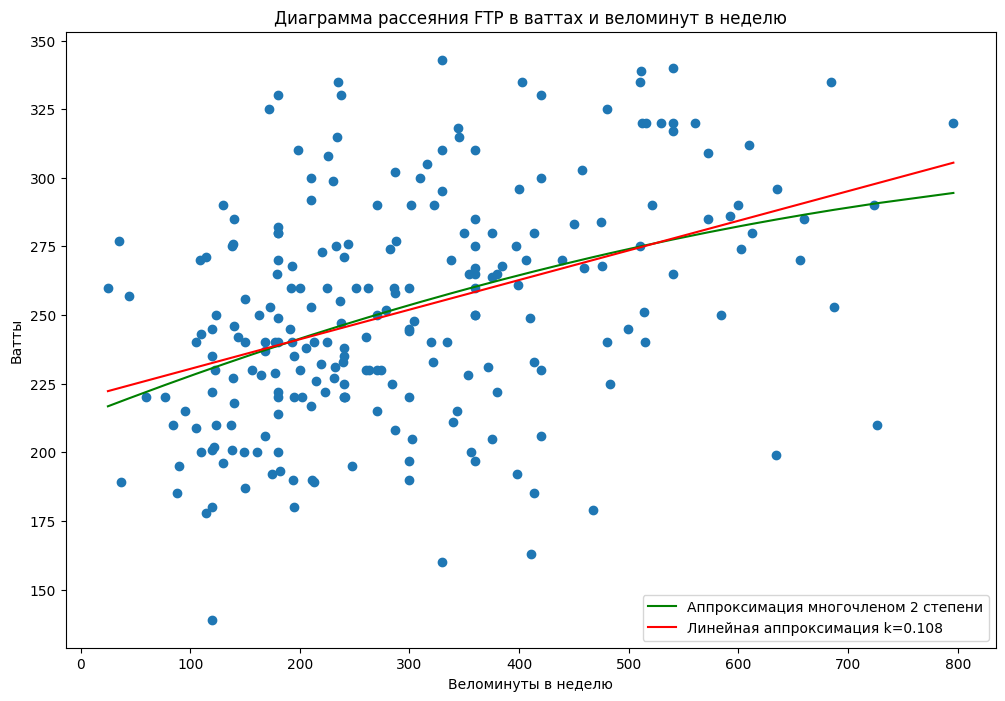

In [35]:
sc = data[['bike_minute', 'ftp_c']].sort_values(by='bike_minute')
plt.figure(figsize=(12,8))
plt.scatter(sc['bike_minute'], sc['ftp_c'])

z = np.polyfit(sc['bike_minute'], sc['ftp_c'], 2)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='green', label = 'Аппроксимация многочленом 2 степени')

z = np.polyfit(sc['bike_minute'], sc['ftp_c'], 1)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='red', label = f'Линейная аппроксимация k={round(z[0], 3)}')

plt.title('Диаграмма рассеяния FTP в ваттах и веломинут в неделю')
plt.ylabel('Ватты')
plt.xlabel('Веломинуты в неделю')
plt.legend()
plt.show()

In [36]:
print(f'Коэффициент линиейной аппроксимации FTP и веломинут: {round(z[0], 3)}')
print(f'Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на {round(z[0] * 60, 3)} ватт')

Коэффициент линиейной аппроксимации FTP и веломинут: 0.108
Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на 6.476 ватт


Однако, при этом данные, хорошо аппоксимируются и квадратичной фукнцией, которая показывает уменьшающийся прирост на больших веломинутах

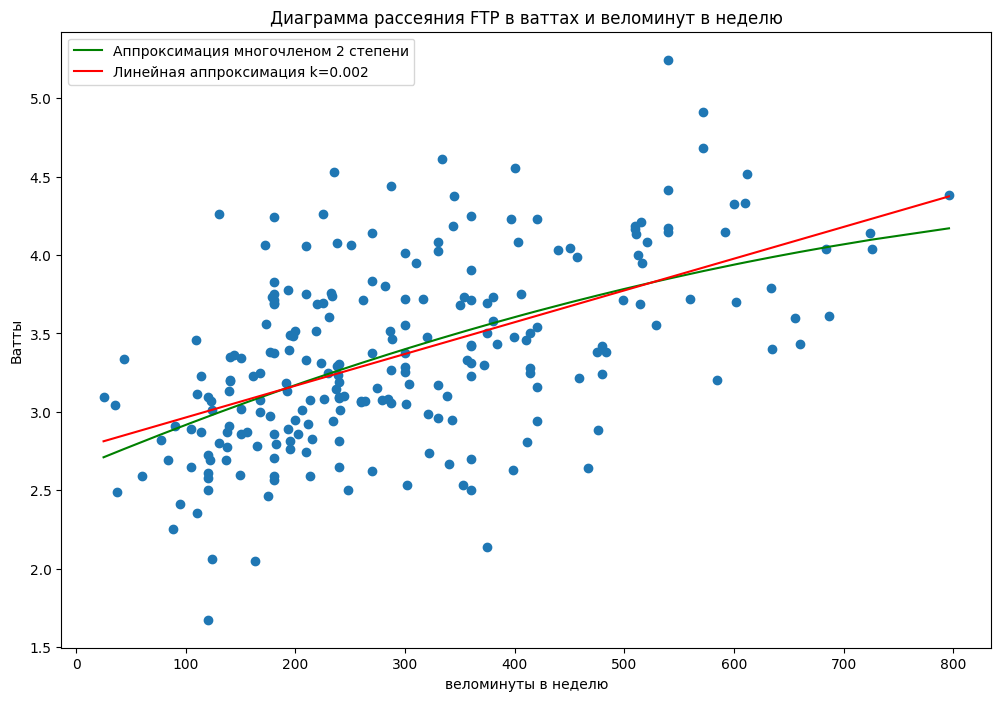

In [37]:
sc = data[['bike_minute', 'ftp_weigth']].sort_values(by='bike_minute')
plt.figure(figsize=(12,8))
plt.scatter(sc['bike_minute'], sc['ftp_weigth'])

z = np.polyfit(sc['bike_minute'], sc['ftp_weigth'], 2)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='green', label = 'Аппроксимация многочленом 2 степени')

z = np.polyfit(sc['bike_minute'], sc['ftp_weigth'], 1)
p = np.poly1d(z)
plt.plot(sc['bike_minute'], p(sc['bike_minute']), color='red', label = f'Линейная аппроксимация k={round(z[0], 3)}')

plt.title('Диаграмма рассеяния FTP в ваттах и веломинут в неделю')
plt.ylabel('Ватты')
plt.xlabel('веломинуты в неделю')
plt.legend()
plt.show()

In [38]:
print(f'Коэффициент линиейной аппроксимации FTP и веломинут: {round(z[0], 3)}')
print(f'Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на {round(z[0] * 60, 3)} ватт/кг')

Коэффициент линиейной аппроксимации FTP и веломинут: 0.002
Это можно интерпретировать так: у спортсменов, которые тренируются в неделю на один час больше, в среднем и FTP больше на 0.122 ватт/кг


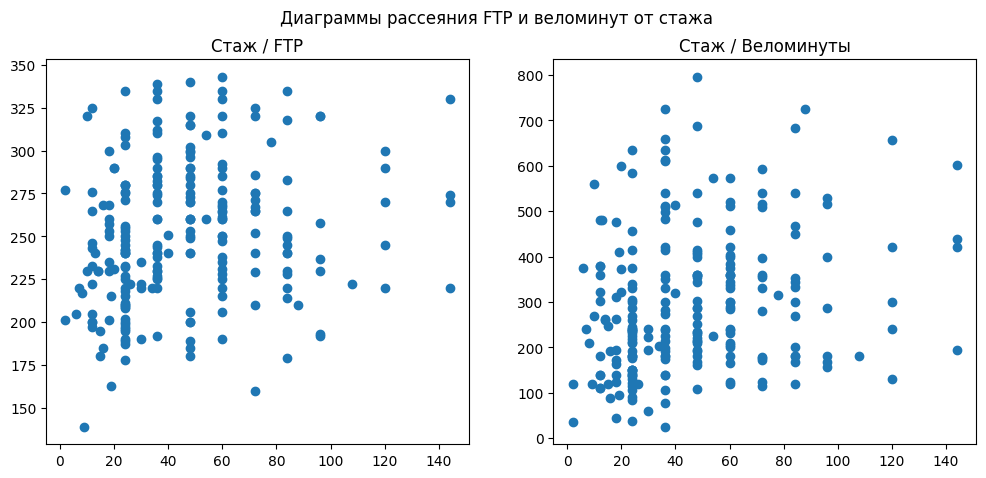

In [39]:
f, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].scatter(data['stag_r'], data['ftp_c'])
ax[0].set_title('Стаж / FTP')
ax[1].scatter(data['stag_r'], data['bike_minute'])
ax[1].set_title('Стаж / Веломинуты')
plt.suptitle('Диаграммы рассеяния FTP и веломинут от стажа')
plt.show()

Каких-то зависимостей от стажа из диаграмы расеяния не обнаруживается

# Когортный анализ

### Когорты по FTP

Разделим спортменов на когорты **по завяленным FTP** - от 170 до 350+ с шагом в 20 ватт

In [40]:
ftp_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
ftp_stag_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))

qstr_last = ''
ftpbox = dict()
for i in range(190, 350, 20):
    qstr = qstr_last + 'ftp_c <= ' + str(i)
    #print(qstr)
    ftpbox[i]= data.query(qstr)[['bike_minute', 'stag_r']]
    ftp_describe.loc[i] = ftpbox[i]['bike_minute'].describe()
    ftp_stag_describe.loc[i] = ftpbox[i]['stag_r'].describe()
    qstr_last =  str(i) + ' < '
ftpbox[999]= data.query('330 < ftp_c')[['bike_minute', 'stag_r']]
ftp_describe.loc[999] = ftpbox[999]['bike_minute'].describe()
ftp_stag_describe.loc[999] = ftpbox[999]['stag_r'].describe()

`Таблица статиcтичеcких характеристик когорт. Индекс - верхняя граница когорты`

In [41]:
pd.merge(ftp_describe, ftp_stag_describe, how = 'left', left_index=True, right_index=True, suffixes=('_minute', '_stag'))

,count_minute,mean_minute,std_minute,min_minute,25%_minute,50%_minute,75%_minute,max_minute,count_stag,mean_stag,std_stag,min_stag,25%_stag,50%_stag,75%_stag,max_stag
190,15.0,224.266667,131.429757,37.0,120.00,195.0,315.00,467.0,15.0,36.333333,22.483857,9.0,21.5,24.0,48.0,84.0
210,27.0,243.740741,163.138118,84.0,127.00,175.0,329.00,726.0,27.0,34.111111,26.801741,2.0,16.5,24.0,48.0,96.0
230,37.0,228.891892,93.092184,60.0,177.00,223.0,270.00,483.0,37.0,45.891892,34.236744,7.0,24.0,36.0,60.0,144.0
250,43.0,257.744186,118.151858,105.0,172.50,232.0,320.50,584.0,43.0,43.976744,26.466950,12.0,24.0,36.0,60.0,120.0
270,36.0,313.027778,151.696781,25.0,198.25,293.5,387.75,687.0,36.0,52.055556,28.806690,12.0,33.0,48.0,60.0,144.0
290,35.0,348.862857,181.618733,35.0,200.00,322.0,492.50,724.0,35.0,46.800000,28.681619,2.0,24.0,36.0,60.0,144.0
310,16.0,343.187500,128.665053,198.0,229.00,323.0,405.00,635.0,16.0,47.625000,25.120709,18.0,33.0,48.0,55.5,120.0
330,16.0,438.500000,173.548456,172.0,317.50,496.0,540.00,796.0,16.0,59.875000,34.132829,10.0,36.0,54.0,75.0,144.0
999,7.0,459.000000,148.573214,235.0,366.50,510.0,525.50,684.0,7.0,49.714286,20.113961,24.0,36.0,48.0,60.0,84.0


Диаграммы размаха когорт

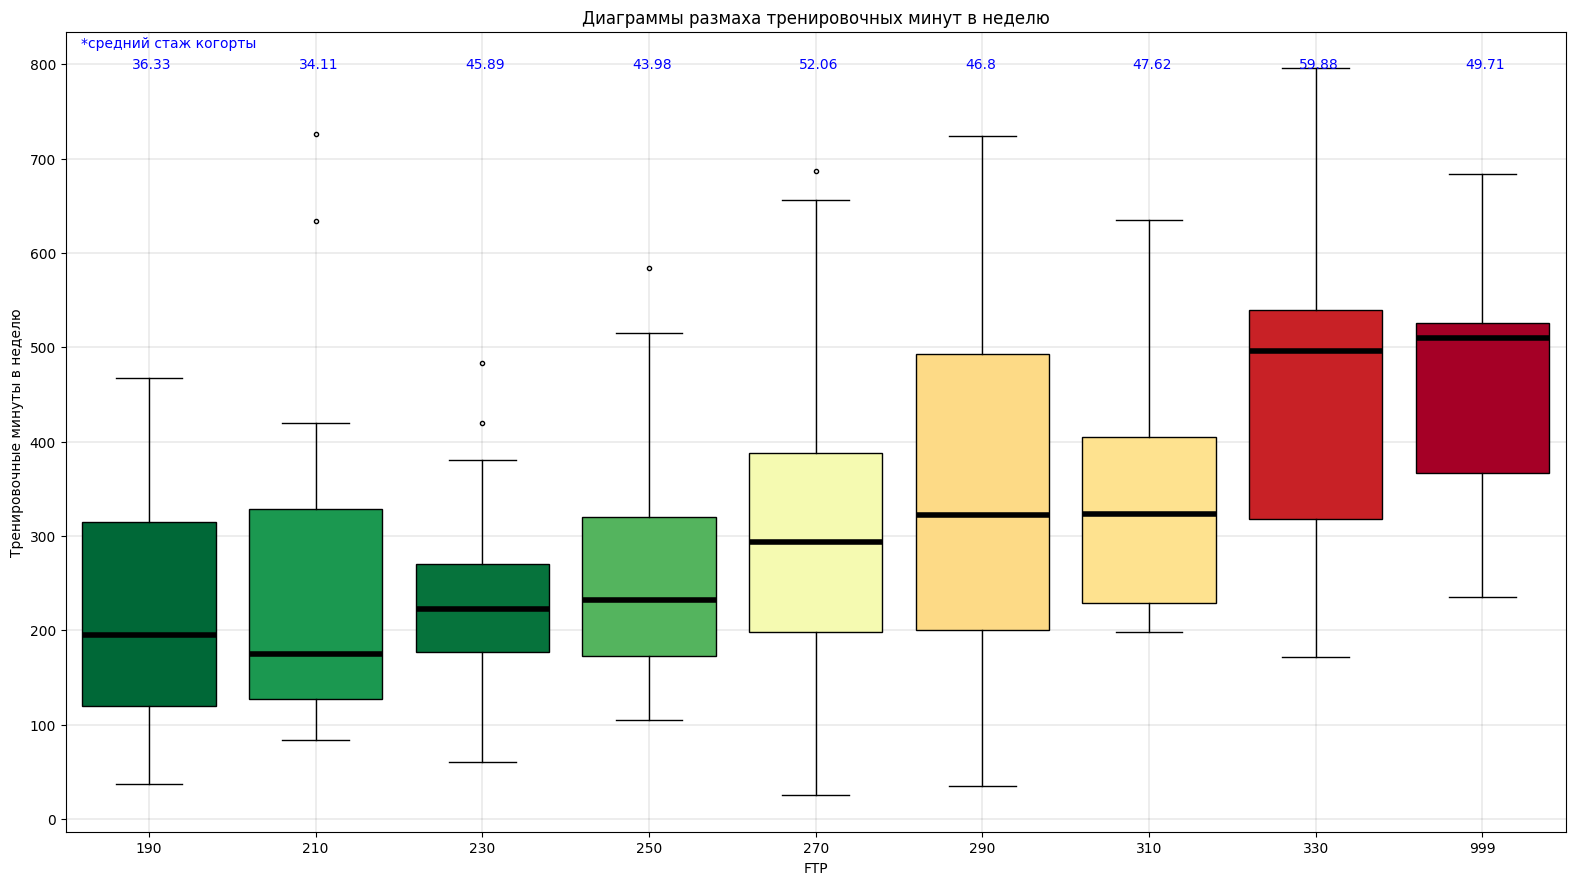

In [42]:
c = gradient_by_value(ftp_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for fb in ftpbox:
    ax.boxplot(ftpbox[fb]['bike_minute'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, ftp_describe['max'].max(), f"{round(ftp_stag_describe.loc[fb, 'mean'], 2)}", color= 'blue')
    i +=1

plt.annotate('*средний стаж когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха тренировочных минут в неделю')
plt.xlabel('FTP')
plt.ylabel('Тренировочные минуты в неделю')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

Цвет тела середины "ящика с усами" определяется нормировкой среднего значения когорты по трехцветному градиенту, где красный - маскимальное среднее значение целевого показателя среди всех когорт, зеленый - минмальное значние, желтый - среднее значение.

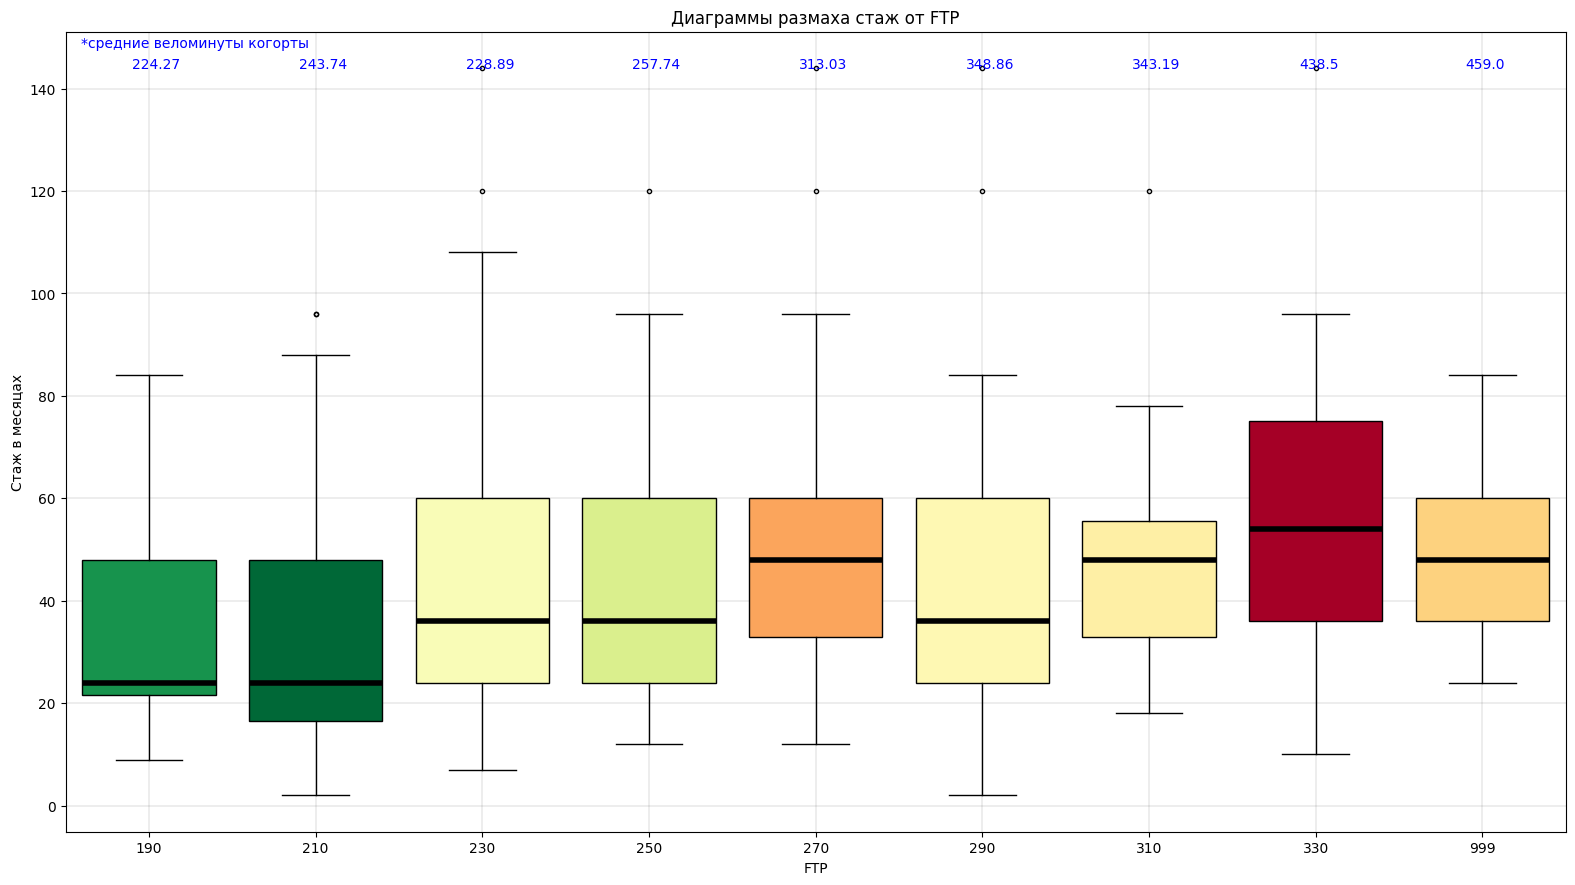

In [43]:
c = gradient_by_value(ftp_stag_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for fb in ftpbox:
    ax.boxplot(ftpbox[fb]['stag_r'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, ftp_stag_describe['max'].max(), f"{round(ftp_describe.loc[fb, 'mean'], 2)}", color= 'blue')
    i +=1

plt.annotate('*средние веломинуты когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха стаж от FTP')
plt.xlabel('FTP')
plt.ylabel('Стаж в месяцах')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

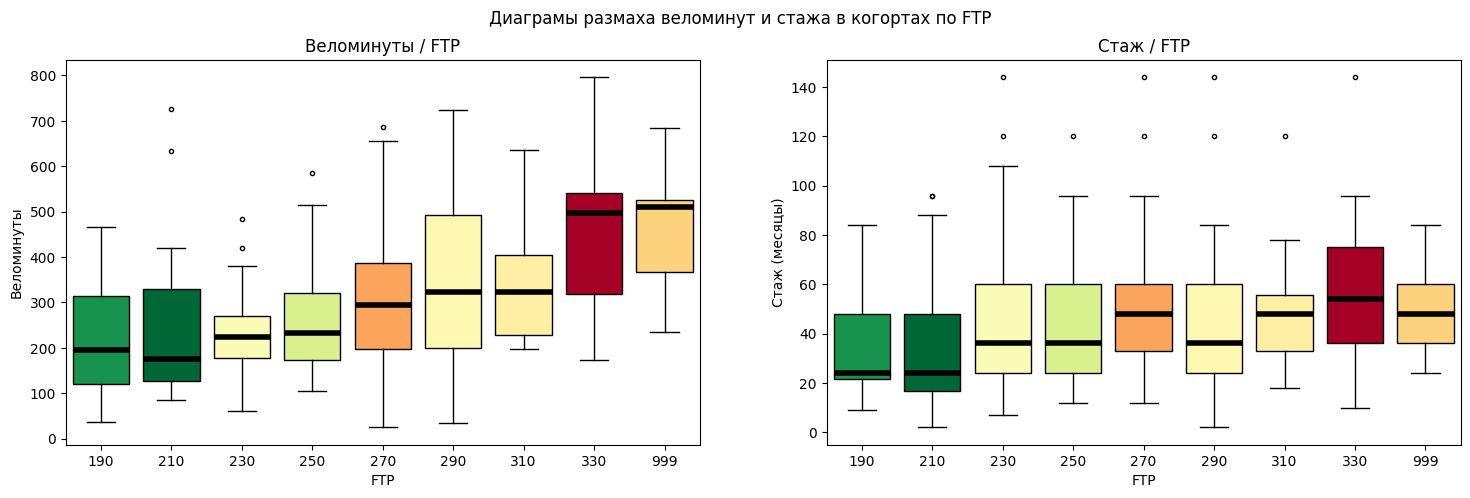

In [44]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

c = gradient_by_value(ftp_stag_describe['mean'])
i = 0
for fb in ftpbox:
    ax[0].boxplot(ftpbox[fb]['bike_minute'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[0].set_title('Веломинуты / FTP')
ax[0].set_xlabel('FTP')
ax[0].set_ylabel('Веломинуты')


c = gradient_by_value(ftp_stag_describe['mean'])
i = 0
for fb in ftpbox:
    ax[1].boxplot(ftpbox[fb]['stag_r'], positions=[i], labels = [fb], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[1].set_title('Стаж / FTP')
ax[1].set_xlabel('FTP')
ax[1].set_ylabel('Стаж (месяцы)')

plt.suptitle('Диаграмы размаха веломинут и стажа в когортах по FTP')
plt.show()



В когортах по FTP проявляется взаимосвязь с веломинутами. Чем больше FTP, тем большие веломинуты указывали спорстмены в опросе. А вот со стажей связи както не просматриватеся. Во всех когортах по FTP вполне сопоставимые значения тренировочного стажа.

### Когорты по веломинутам

Разделим спортменов на когорты **по веломинутам** в минутах - от 60 до 600+ с шагом в 60

In [45]:
bikeminut_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
bikeminut_stag_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))

qstr_last = ''
bikeminutbox = dict()
for i in range(120, 600, 60):
    qstr = qstr_last + 'bike_minute <= ' + str(i)
    #print(qstr)
    bikeminutbox[i] = data.query(qstr)[['ftp_c', 'stag_r']]
    qstr_last =  str(i) + ' < '
    bikeminut_describe.loc[i] = bikeminutbox[i]['ftp_c'].describe()
    bikeminut_stag_describe.loc[i] = bikeminutbox[i]['stag_r'].describe()
bikeminutbox[999]= data.query('540 < bike_minute')[['ftp_c', 'stag_r']]
bikeminut_describe.loc[999] = bikeminutbox[999]['ftp_c'].describe()
bikeminut_stag_describe.loc[999] = bikeminutbox[999]['stag_r'].describe()


`Таблица статиcтичеcких характеристик когорт. Индекс - верхняя граница когорты`

In [46]:
pd.merge(bikeminut_describe, bikeminut_stag_describe, how = 'left', left_index=True, right_index=True, suffixes=('_ftp', '_stag'))

,count_ftp,mean_ftp,std_ftp,min_ftp,25%_ftp,50%_ftp,75%_ftp,max_ftp,count_stag,mean_stag,std_stag,min_stag,25%_stag,50%_stag,75%_stag,max_stag
120,23.0,220.043478,34.931723,139.0,197.50,220.0,244.00,277.0,23.0,28.391304,20.770913,2.0,15.5,24.0,36.0,84.0
180,43.0,240.069767,34.469721,187.0,212.00,240.0,260.50,330.0,43.0,44.372093,29.163760,12.0,24.0,36.0,66.0,120.0
240,44.0,247.431818,38.021045,180.0,224.25,239.0,268.75,335.0,44.0,44.000000,26.452239,8.0,24.0,36.0,49.5,144.0
300,27.0,242.222222,28.884829,190.0,222.50,244.0,260.00,302.0,27.0,44.222222,28.812835,7.0,24.0,36.0,60.0,120.0
360,31.0,261.935484,42.496224,160.0,236.50,265.0,292.50,343.0,31.0,48.000000,22.491480,12.0,30.0,48.0,60.0,84.0
420,22.0,251.818182,45.152268,163.0,224.00,262.5,278.75,335.0,22.0,50.590909,34.691373,6.0,24.0,48.0,60.0,144.0
480,9.0,268.777778,41.321235,179.0,267.00,270.0,284.00,325.0,9.0,54.111111,44.177043,12.0,18.0,48.0,84.0,144.0
540,15.0,293.466667,39.817201,225.0,258.00,317.0,320.00,340.0,15.0,58.666667,22.356420,36.0,36.0,60.0,72.0,96.0
999,18.0,281.333333,35.831304,199.0,271.00,285.5,305.75,335.0,18.0,54.222222,35.525559,10.0,36.0,42.0,69.0,144.0


Диаграммы размаха когорт

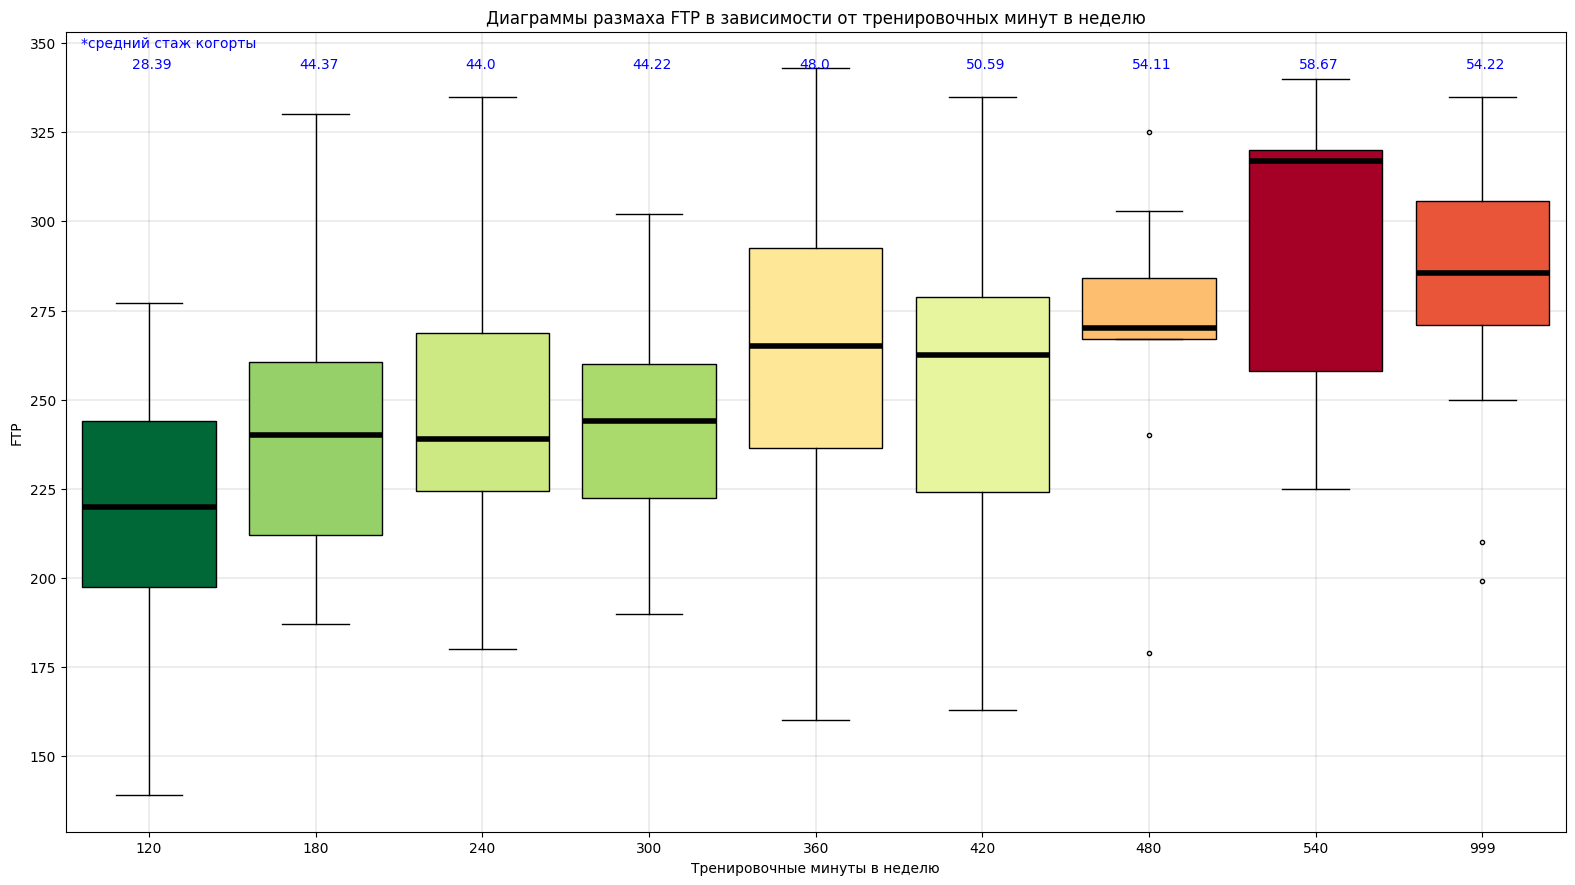

In [47]:
c = gradient_by_value(bikeminut_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in bikeminutbox:
    ax.boxplot(bikeminutbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, bikeminut_describe['max'].max(), f"{round(bikeminut_stag_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1

plt.annotate('*средний стаж когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха FTP в зависимости от тренировочных минут в неделю')
plt.xlabel('Тренировочные минуты в неделю')
plt.ylabel('FTP')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

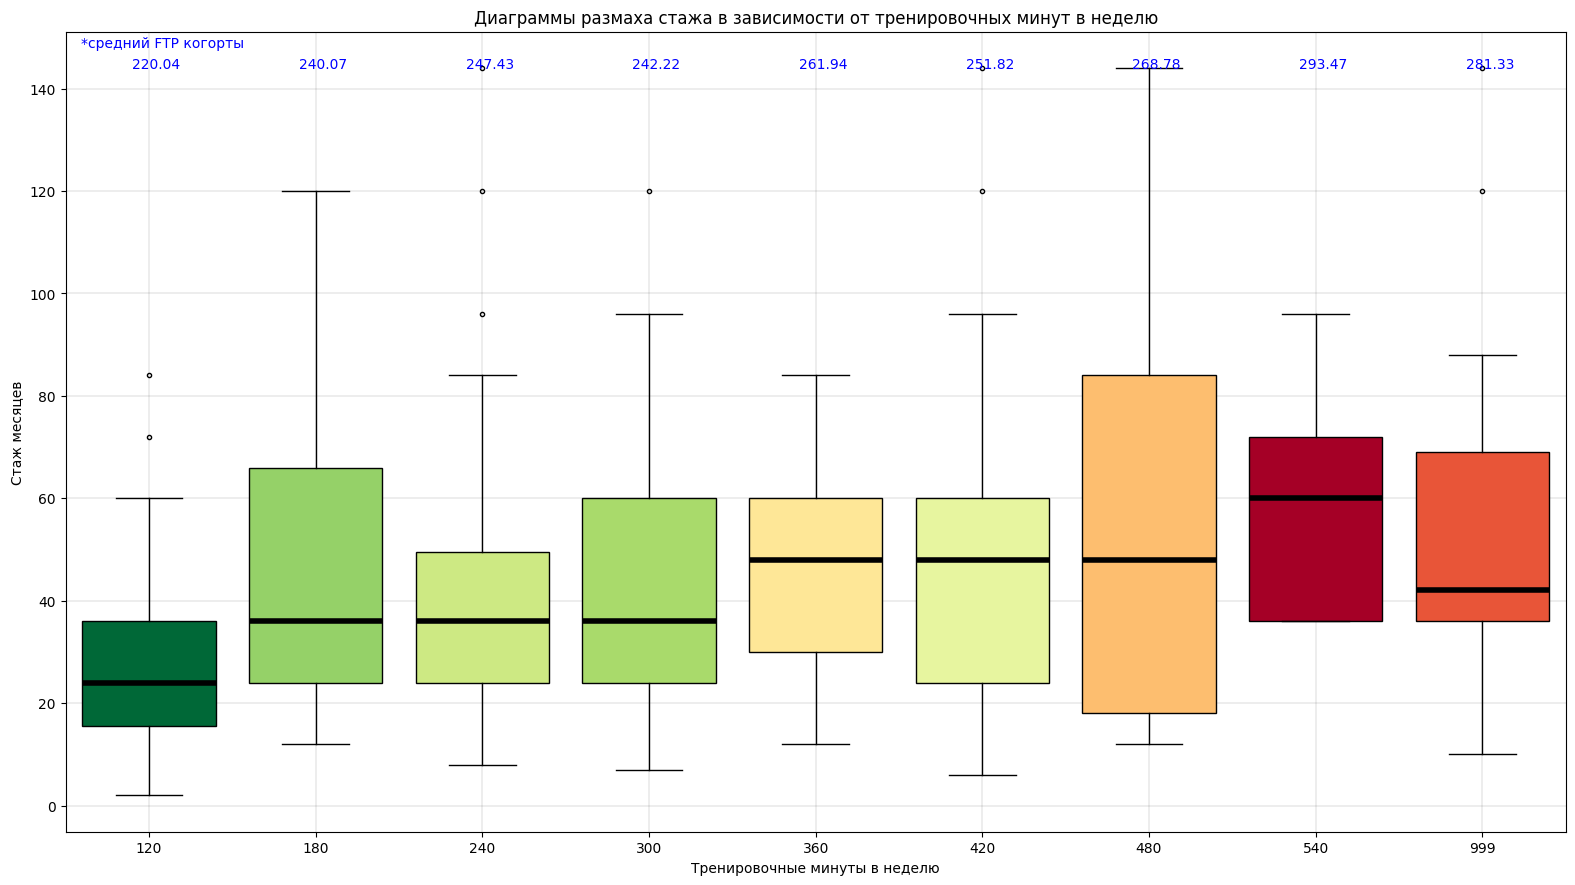

In [48]:
c = gradient_by_value(bikeminut_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in bikeminutbox:
    ax.boxplot(bikeminutbox[bk]['stag_r'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, bikeminut_stag_describe['max'].max(), f"{round(bikeminut_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1
plt.annotate('*средний FTP когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха стажа в зависимости от тренировочных минут в неделю')
plt.xlabel('Тренировочные минуты в неделю')
plt.ylabel('Стаж месяцев')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

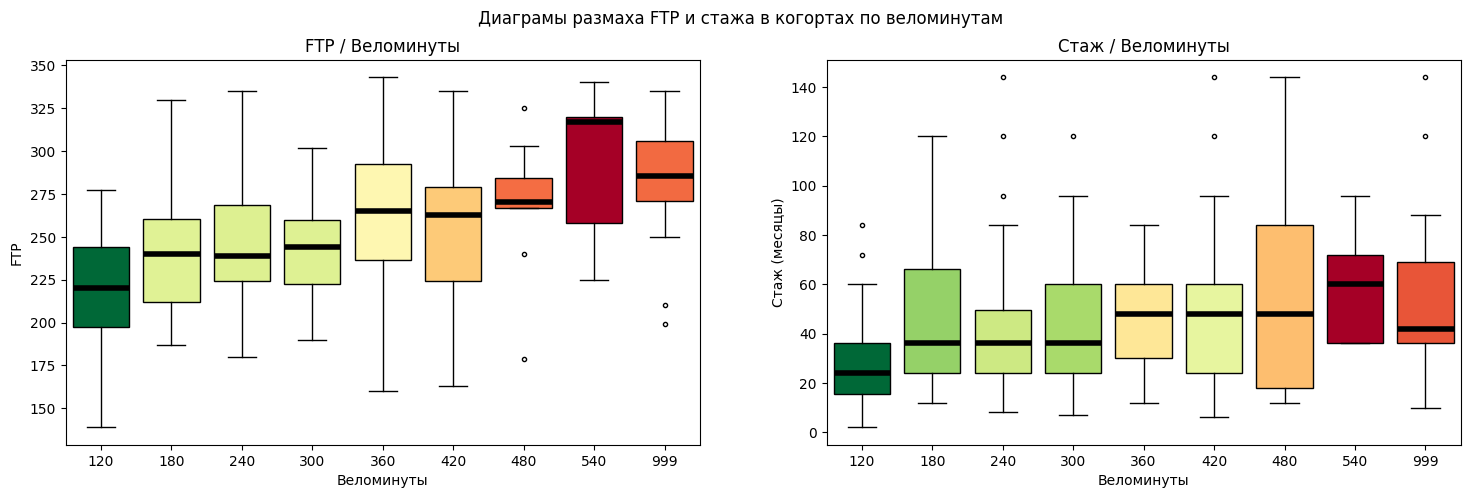

In [49]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

c = gradient_by_value(bikeminut_stag_describe['mean'])
i = 0
for bk in bikeminutbox:
    ax[0].boxplot(bikeminutbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[0].set_title('FTP / Веломинуты')
ax[0].set_xlabel('Веломинуты')
ax[0].set_ylabel('FTP')


c = gradient_by_value(bikeminut_describe['mean'])
i = 0
for bk in bikeminutbox:
    ax[1].boxplot(bikeminutbox[bk]['stag_r'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[1].set_title('Стаж / Веломинуты')
ax[1].set_xlabel('Веломинуты')
ax[1].set_ylabel('Стаж (месяцы)')

plt.suptitle('Диаграмы размаха FTP и стажа в когортах по веломинутам')
plt.show()

В когортах также прослеживается взаимосязь роста веломинут с ростом FTP. Примечательно, что не просматривется связи роста веломинут со стажем.

### Когорты по тренирочному стажу

Разделим спортменов на когорты **по тренировочному стажу** в месяцах - от 18 до 90+ с шагом в 12

In [50]:
stag_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))
stag_ftp_describe = pd.DataFrame(columns = ('count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'))

qstr_last = ''
stagbox = dict()
for i in range(18, 100, 12):
    qstr = qstr_last + 'stag_r <= ' + str(i)
    #print(qstr)
    stagbox[i]= data.query(qstr)[['bike_minute', 'ftp_c']]
    stag_describe.loc[i] = stagbox[i]['bike_minute'].describe()
    stag_ftp_describe.loc[i] = stagbox[i]['ftp_c'].describe()
    qstr_last =  str(i) + ' < '
stagbox[999]= data.query('90 < stag_r')[['bike_minute', 'ftp_c']]
stag_describe.loc[999] = stagbox[999]['bike_minute'].describe()
stag_ftp_describe.loc[999] = stagbox[999]['ftp_c'].describe()

In [51]:
pd.merge(stag_describe, stag_ftp_describe, how = 'left', left_index=True, right_index=True, suffixes=('_minute', '_ftp'))

,count_minute,mean_minute,std_minute,min_minute,25%_minute,50%_minute,75%_minute,max_minute,count_ftp,mean_ftp,std_ftp,min_ftp,25%_ftp,50%_ftp,75%_ftp,max_ftp
18,35.0,239.120000,133.584908,35.0,130.5,210.0,315.5,560.0,35.0,234.371429,39.517744,139.0,203.0,230.0,258.5,325.0
30,53.0,235.320755,130.912886,37.0,144.0,219.0,287.0,634.0,53.0,235.056604,37.848593,163.0,209.0,231.0,255.0,335.0
42,35.0,339.400000,185.734345,25.0,195.0,300.0,504.5,724.0,35.0,265.028571,37.132106,192.0,235.5,260.0,287.5,339.0
54,33.0,323.030303,154.672938,109.0,213.0,286.0,400.0,796.0,33.0,265.000000,41.853166,180.0,249.0,270.0,296.0,340.0
66,29.0,318.034483,116.727241,120.0,232.0,330.0,384.0,572.0,29.0,263.172414,38.878996,190.0,235.0,261.0,285.0,343.0
78,15.0,330.600000,157.750164,114.0,178.0,330.0,453.5,592.0,15.0,263.000000,42.245879,160.0,246.0,267.0,280.5,325.0
90,15.0,354.400000,186.692184,120.0,190.0,334.0,458.5,726.0,15.0,247.066667,40.515370,179.0,224.0,240.0,257.5,335.0
999,17.0,342.235294,168.562870,130.0,182.0,300.0,439.0,656.0,17.0,258.294118,43.561400,192.0,222.0,258.0,290.0,330.0


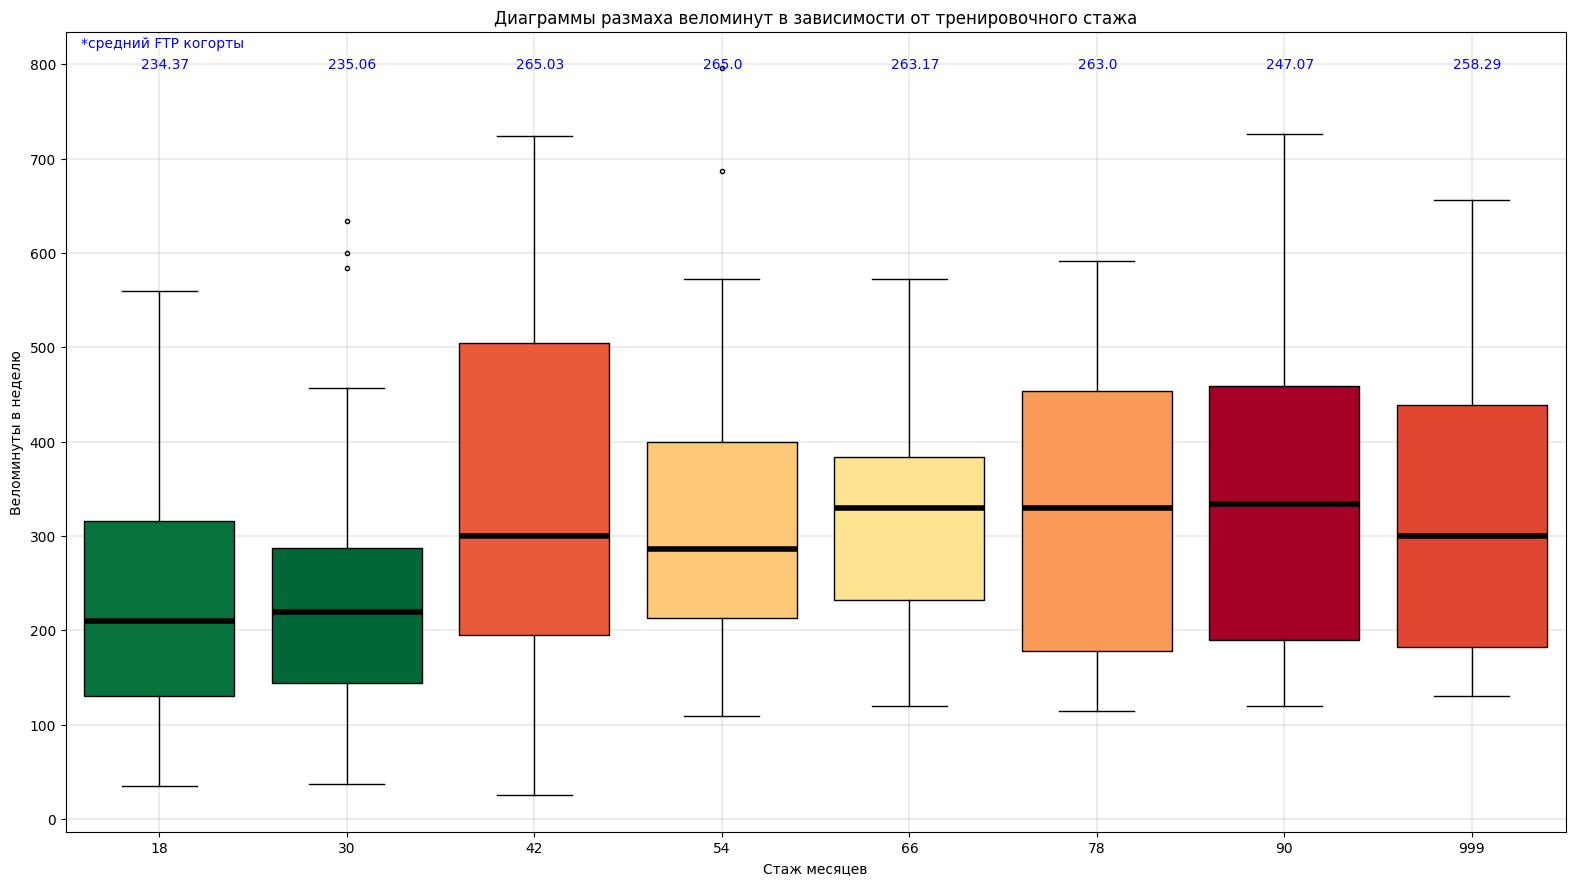

In [52]:
c = gradient_by_value(stag_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in stagbox:
    ax.boxplot(stagbox[bk]['bike_minute'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, stag_describe['max'].max(), f"{round(stag_ftp_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1
plt.annotate('*средний FTP когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха веломинут в зависимости от тренировочного стажа')
plt.xlabel('Стаж месяцев')
plt.ylabel('Веломинуты в неделю')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

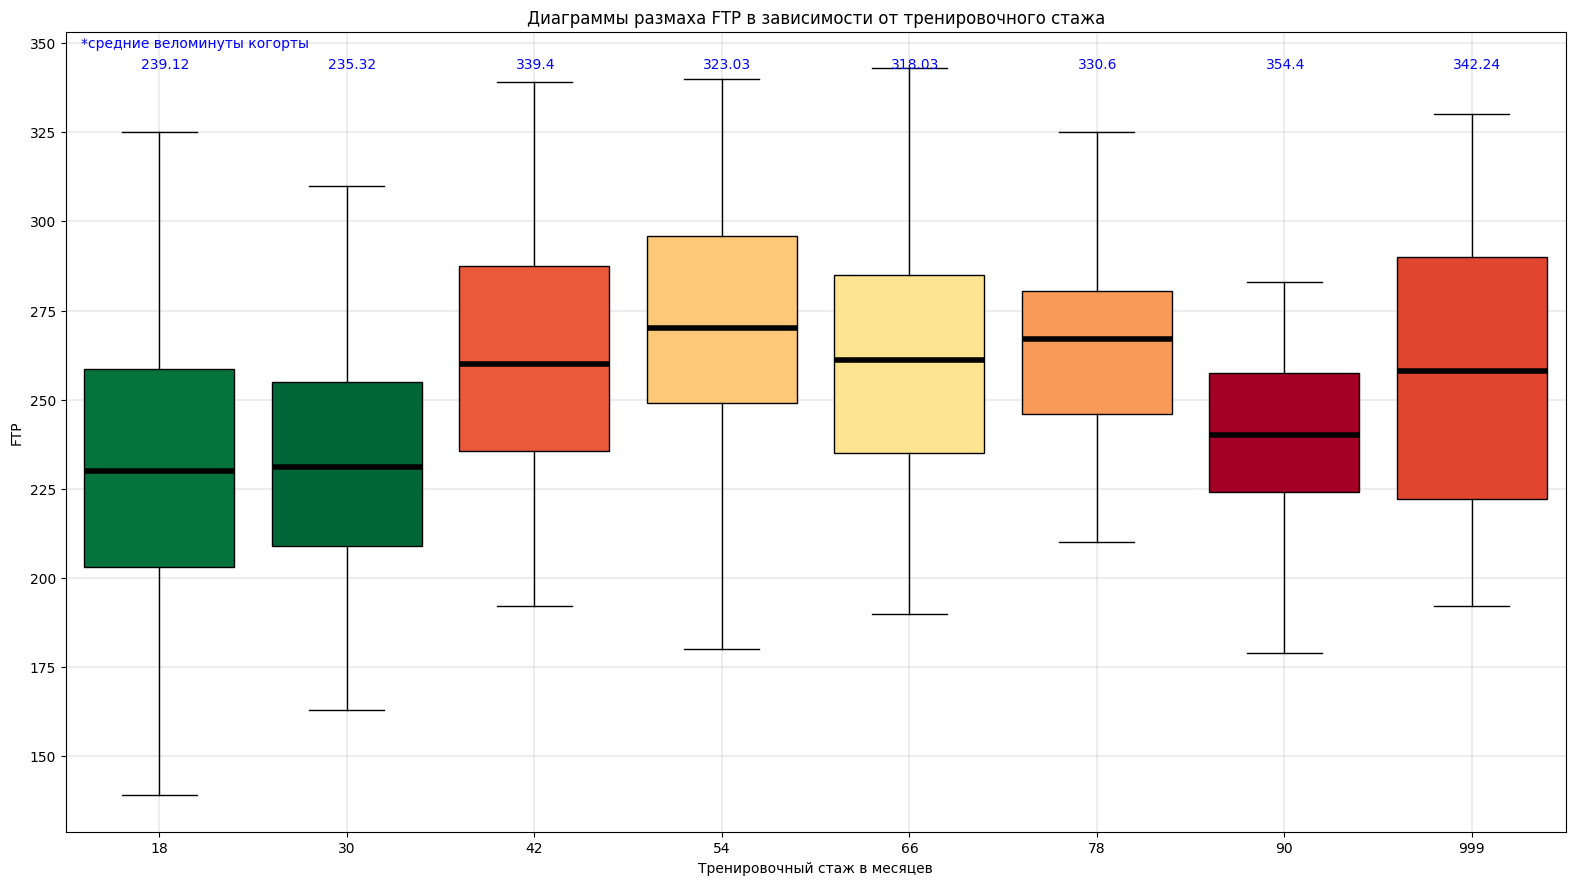

In [53]:
c = gradient_by_value(stag_describe['mean'])
i = 0

fig = plt.figure(figsize = (15, 8))
ax = fig.add_axes([0, 0, 1, 1])
for bk in stagbox:
    ax.boxplot(stagbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    ax.text(i-0.1, stag_ftp_describe['max'].max(), f"{round(stag_describe.loc[bk, 'mean'], 2)}", color= 'blue')
    i +=1
plt.annotate('*средние веломинуты когорты', color = 'blue', xy=(0.01, 0.98), xycoords='axes fraction')
plt.title('Диаграммы размаха FTP в зависимости от тренировочного стажа')
plt.xlabel('Тренировочный стаж в месяцев')
plt.ylabel('FTP')
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.show()

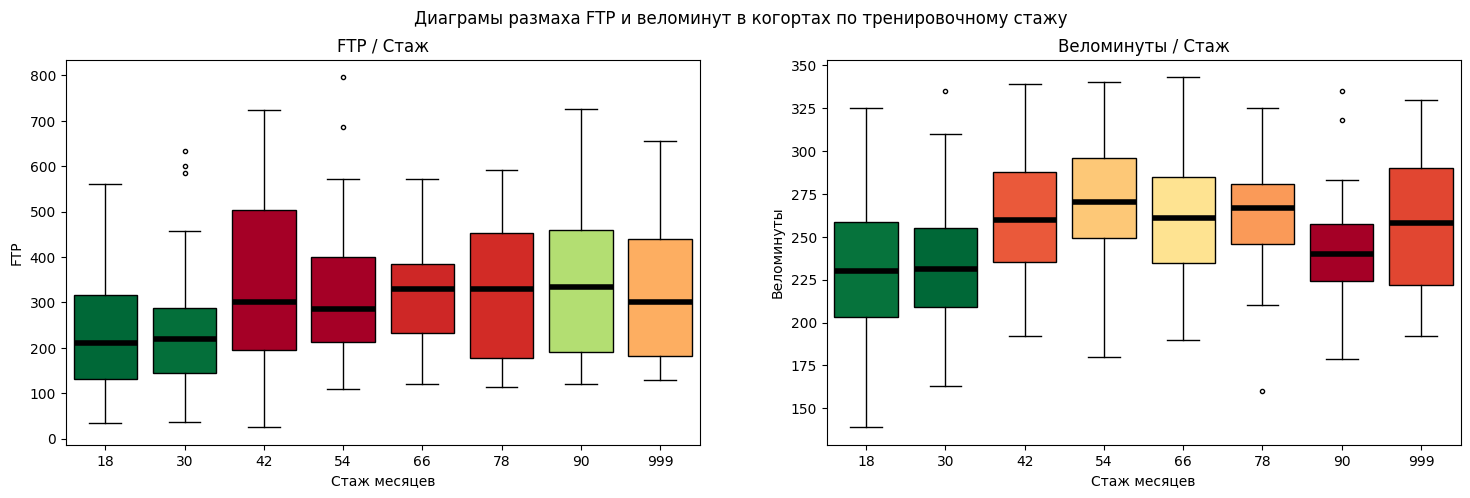

In [54]:
f, ax = plt.subplots(1, 2, figsize=(18,5))

c = gradient_by_value(stag_ftp_describe['mean'])
i = 0
for bk in stagbox:
    ax[0].boxplot(stagbox[bk]['bike_minute'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[0].set_title('FTP / Стаж')
ax[0].set_xlabel('Стаж месяцев')
ax[0].set_ylabel('FTP')


c = gradient_by_value(stag_describe['mean'])
i = 0
for bk in stagbox:
    ax[1].boxplot(stagbox[bk]['ftp_c'], positions=[i], labels = [bk], widths = 0.8 , sym = '.',\
               patch_artist=True, boxprops=dict(facecolor=c[i]), medianprops=dict(color='black', linewidth=4))
    i +=1
ax[1].set_title('Веломинуты / Стаж')
ax[1].set_xlabel('Стаж месяцев')
ax[1].set_ylabel('Веломинуты')

plt.suptitle('Диаграмы размаха FTP и веломинут в когортах по тренировочному стажу')
plt.show()

Данные говорят, что в начале "спортивной карьеры" спорстмены вцелом не злоупотреляют веломинутами.

Наибольшее количество велотренировок приходится на 3-6 годы занятия спортом, что сказывается и на росте FTP.

Дальше, похоже, спортсмены переходят в режим поддержания формы и даже несколько снижают объемы велотенировок.

Только единицы, видимо, добившиеся определенных успехов и результатов, продолжают поддерживать или наращивать объемы тренировок и высокие FTP.

# Волновой характер роста FTP с ростом веломинут

Когортный анализ показал, что FTP с увеличением веломинут по когортам растет не монотонно! Угадывается некий волновой характер, накладывающийся на линейную зависимость роста веломинут и FTP.

Изучим этот эффект по подробнее...

Аппроксимируем данные многочленами высоких степеней

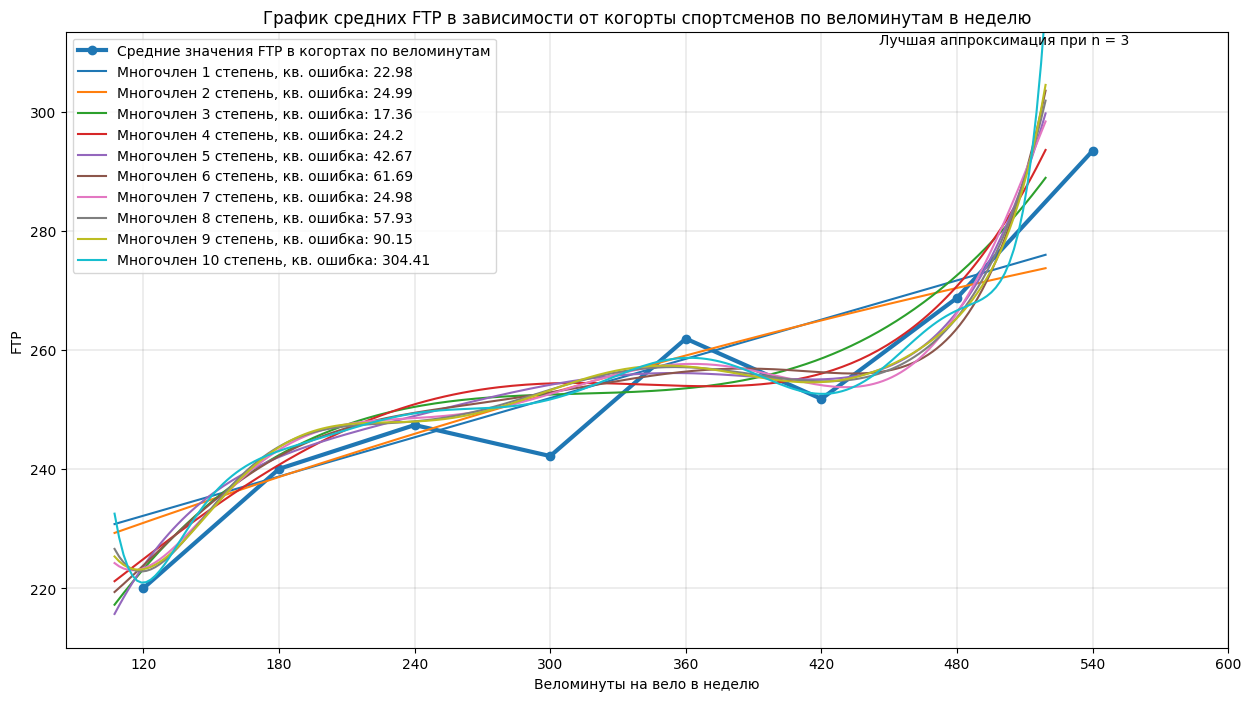

In [55]:
xmin = data['bike_minute'].quantile(0.05)
xmax = data['bike_minute'].quantile(0.90)
sc = data.query('bike_minute > @xmin & bike_minute < @xmax')[['bike_minute', 'ftp_c']].sort_values(by='bike_minute')

fig = plt.figure(figsize = (15, 8))

plt.plot(bikeminut_describe.index[0:-1], bikeminut_describe['mean'][0:-1], linewidth = 3, marker="o", color='tab:blue', label = 'Средние значения FTP в когортах по веломинутам')

sslast = 99999999999
for i in range(1, 11):
  z = np.polyfit(sc['bike_minute'], sc['ftp_c'], i)
  p = np.poly1d(z)
  ss = 0
  for x in bikeminut_describe.index[1:-1]:
    ss = ss + (p(x) - bikeminut_describe.loc[x, 'mean']) ** 2
    #print(p(x), bikeminut_describe.loc[x, 'mean'])
  if sslast > ss:
     sslast = ss
     bestn = i
  x = np.arange(xmin, xmax, 2)
  plt.plot(x, p(x), label = f'Многочлен {i} степень, кв. ошибка: {round(math.sqrt(ss), 2)} ')

plt.title('График средних FTP в зависимости от когорты спортсменов по веломинутам в неделю')

plt.annotate(f'Лучшая аппроксимация при n = {bestn}', xy=(0.7, 0.98), xycoords='axes fraction')
plt.xlabel('Веломинуты на вело в неделю')
plt.ylabel('FTP')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.xticks(np.linspace(120, 600, 9))
plt.ylim(bikeminut_describe['mean'].min()-10, bikeminut_describe['mean'].max()+20)
plt.show()

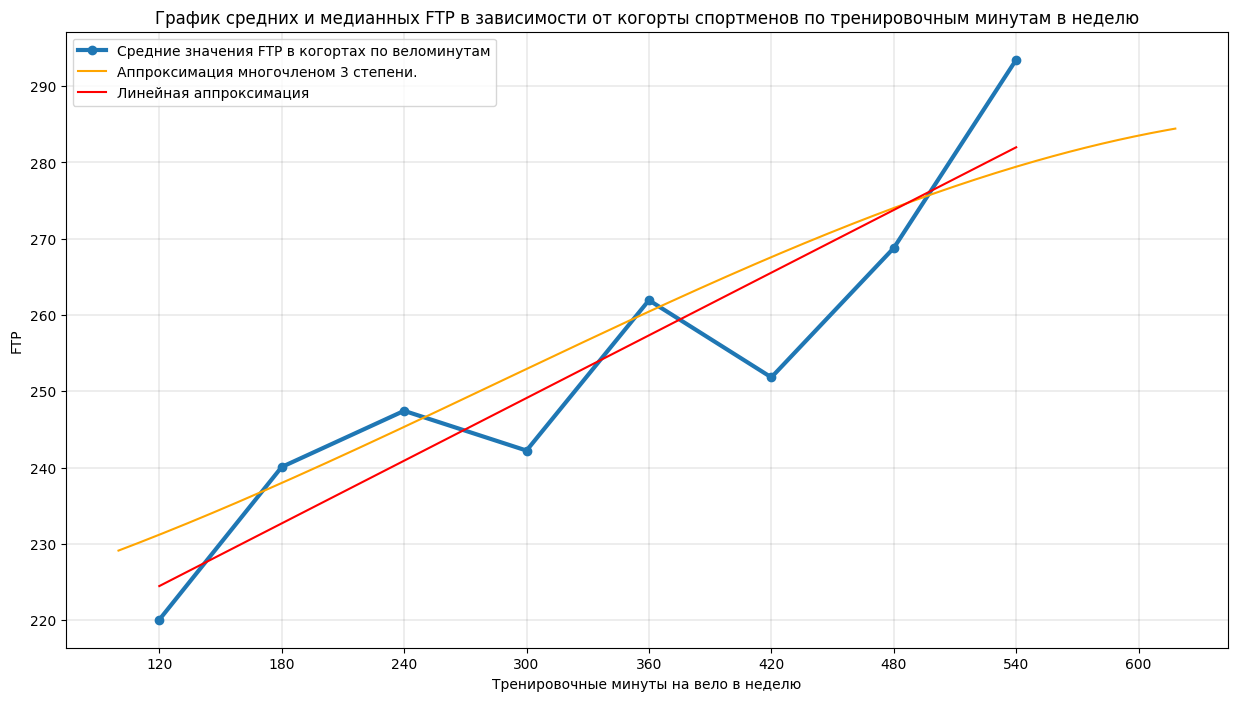

In [56]:
sc = data[['bike_minute', 'ftp_c']].sort_values(by='bike_minute')
xmin = 100
xmax = 620

fig = plt.figure(figsize = (15, 8))
plt.plot(bikeminut_describe.index[0:-1], bikeminut_describe['mean'][0:-1], linewidth = 3, marker="o", color='tab:blue', label = 'Средние значения FTP в когортах по веломинутам')

z = np.polyfit(sc['bike_minute'], sc['ftp_c'], bestn)
p = np.poly1d(z)
x = np.arange(xmin, xmax, 2)

plt.plot(x, p(x), color='orange', label = f'Аппроксимация многочленом {bestn} степени.')

z = np.polyfit(bikeminut_describe.index[0:-1], bikeminut_describe['mean'][0:-1], 1)
p = np.poly1d(z)
plt.plot(bikeminut_describe.index[0:-1], p(bikeminut_describe.index[0:-1]), color='red', label = 'Линейная аппроксимация')

plt.title('График средних и медианных FTP в зависимости от когорты спортменов по тренировочным минутам в неделю')
plt.xlabel('Тренировочные минуты на вело в неделю')
plt.ylabel('FTP')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.xticks(np.linspace(120, 600, 9))
plt.show()

Возможно, это методическая ошибка или неудачное деление на когорты. Но также это можно интерпретировать как неоптимальный объем тренировок: завышение объема, которое не дает прироста FTP, а скорее наоборот. Спортсменам, попавшим в эти локальные минимумы, можно чуть уменьшить объем, и тогда их FTP вырастет.

Была гипотеза, что этот эффект связан с тренировочным стажем, но при рассмотрении когорт по стажу эту гипотеза пришлось отбросить.

Была гипотеза, что "ямы" близки к "круглым" значениям - 300, 420 - это 5 и 7 часов соответственно. Возможно, спортсмены "добивают" объем до круглого числа Но убедительно статистическими тестами подвердить эту гипотезу также не удалось. Хотя, если подкрутить интервалы - получается.

In [57]:
minute_pit = data.query('290 <= bike_minute <= 310 | 410 <= bike_minute <= 420')['ftp_c']
minute_not_pit = data.query('~(290 <= bike_minute <= 310 | 410 <= bike_minute <= 420)')['ftp_c']

In [58]:
print(f'Среднее FTP у спорстменов около 300 и 420 веломинут - {round(minute_pit.mean(),2)}')
print(f'Среднее FTP у спорстменов далеких от 300 и 420 веломинут - {round(minute_not_pit.mean(), 2)}')

Среднее FTP у спорстменов около 300 и 420 веломинут - 240.79
Среднее FTP у спорстменов далеких от 300 и 420 веломинут - 252.49


In [59]:
test_selection(minute_pit,
               minute_not_pit,
               side='less',
               h0 = 'у спорстменом, с объемом веломинут около 300 и 420, FTP как и остальных',
               h1 = 'У спорстменов, с объемом веломинут около 300 и 420, FTP меньше',
               )

Первая выборка размером 19 прошла проверку на нормальное распределение. pval = 0.7851747456308568
Вторая выборка размером 213 прошла проверку на нормальное распределение. pval = 0.13294813921223322
Дисперсии выборок близки. pval = 0.7438623856693426. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!

--- Проводим TTest ---
В результате теста получено p-value 0.11905720672541266
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  у спорстменом, с объемом веломинут около 300 и 420, FTP как и остальных 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.13356248951580552
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  у спорстменом, с объемом веломинут около 300 и 420, FTP как и остальных 


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


Возможно, это просто методическая ошибка и спорстмены просто так упрощенно ответили в опроснике.

# Сравнение тренировок у велосипедистов и триатлетов

Разделим спортсменов на велосипедистов - те у кого только велотренировки, и условных триатлетов - те у кого кроме вело, есть и тренировки по другим видам спорта

In [60]:
velo_only = data[data['train_minute'] < 10].copy()
velo_plus = data[data['train_minute'] > 0].copy()
velo_plus['all_minute'] = velo_plus['bike_minute'] + velo_plus['train_minute']

Проверка на аномалии

In [61]:
velo_plus.query('all_minute > 1200')

,date_answer,weigth,gender,sport,bike_hours,train_hours,train_stag,ftp,ftp_source,stag_r,bike_minute,train_minute,weigth_c,ftp_c,ftp_weigth,ftp_source_c,all_minute
146,2024-12-28 23:42:25.926,71.0,Мужской,Триатлон,08:41:31,12:00:00,"5 лет, 1.5 года структурированных тренировок с переодизацией",290,По результатом полевых тестирований,60,521.0,720.0,71.0,290.0,4.084507,По результатом полевых тестирований,1241.0
161,2024-12-29 08:32:38.001,84.0,Мужской,Триатлон,7:55:07,16:00:00,4,284,По результатом полевых тестирований,48,475.0,960.0,84.0,284.0,3.380952,По результатом полевых тестирований,1435.0


Диаграммы рассеяния FTP и веломинут у велосипедистов, а у триатлетов веломинут и длительность обычных тренировок

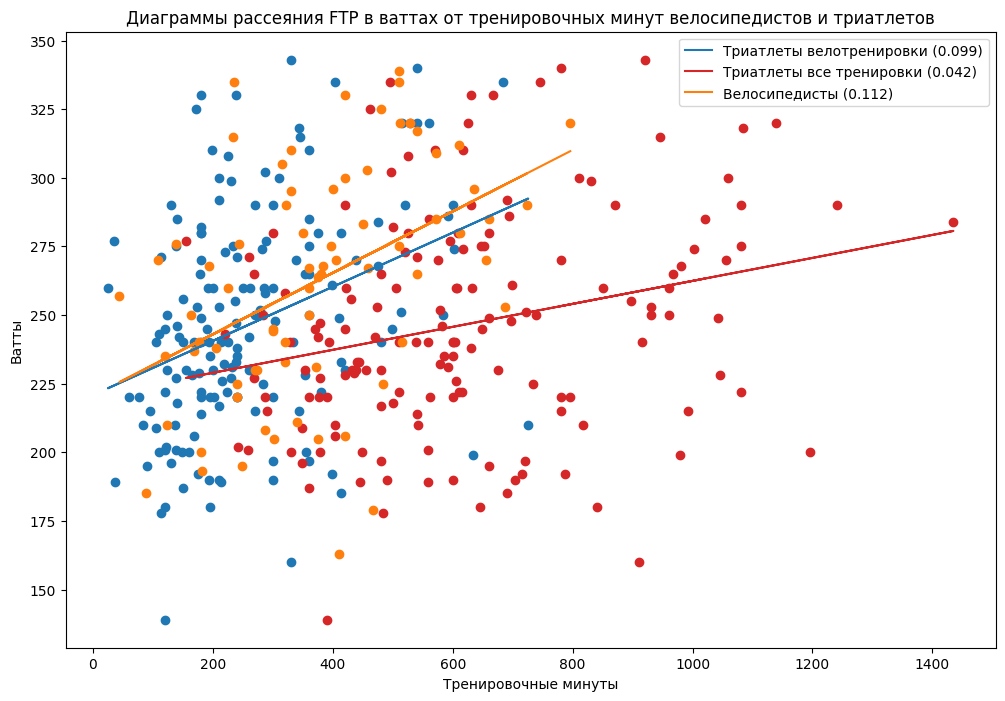

In [62]:
plt.figure(figsize=(12,8))
plt.scatter(velo_plus['bike_minute'], velo_plus['ftp_c'], color='tab:blue')
z = np.polyfit(velo_plus['bike_minute'], velo_plus['ftp_c'], 1)
p = np.poly1d(z)
l = f'Триатлеты велотренировки ({round(z[0], 3)})'
plt.plot(velo_plus['bike_minute'], p(velo_plus['bike_minute']), color='tab:blue', label = l)

plt.scatter(velo_plus['all_minute'], velo_plus['ftp_c'], color='tab:red')
z = np.polyfit(velo_plus['all_minute'], velo_plus['ftp_c'], 1)
p = np.poly1d(z)
l = f'Триатлеты все тренировки ({round(z[0], 3)})'
plt.plot(velo_plus['all_minute'], p(velo_plus['all_minute']), color='tab:red', label = l)


plt.scatter(velo_only['bike_minute'], velo_only['ftp_c'], color='tab:orange')
z = np.polyfit(velo_only['bike_minute'], velo_only['ftp_c'], 1)
p = np.poly1d(z)
l = f'Велосипедисты ({round(z[0], 3)})'
plt.plot(velo_only['bike_minute'], p(velo_only['bike_minute']), color='tab:orange', label = l)

plt.title('Диаграммы рассеяния FTP в ваттах от тренировочных минут велосипедистов и триатлетов')
plt.ylabel('Ватты')
plt.xlabel('Тренировочные минуты')
plt.legend()
plt.show()

Статистические характеристики велосипедистов

In [63]:
velo_only[['ftp_c', 'bike_minute']].rename(columns = {'ftp_c' : 'FTP', 'bike_minute' : 'Веломинуты'}).describe().T

,count,mean,std,min,25%,50%,75%,max
FTP,73.0,262.383562,42.094678,163.0,233.0,267.0,295.0,339.0
Веломинуты,73.0,373.263014,164.608306,44.0,244.0,360.0,483.0,796.0


Статистические характеристики триатлетов

In [64]:
velo_plus[['ftp_c', 'bike_minute', 'all_minute']].rename(columns = {'ftp_c' : 'FTP', 'bike_minute' : 'Веломинуты', 'all_minute' : 'Все тренировки'}).describe().T

,count,mean,std,min,25%,50%,75%,max
FTP,159.0,246.553459,40.180549,139.0,220.0,242.0,274.0,343.0
Веломинуты,159.0,260.679245,138.750223,25.0,168.0,226.0,340.5,726.0
Все тренировки,159.0,620.628931,238.739426,155.0,444.5,596.0,742.0,1435.0


Доля велотренировок у триатетов

In [65]:
velo_plus['train_prob'] = round(100 * velo_plus['bike_minute'] / velo_plus['all_minute'], 2)
print(f"Средняя доля велотренировок у триатлетов - {round(velo_plus['train_prob'].mean(), 2)}%")

Средняя доля велотренировок у триатлетов - 43.31%


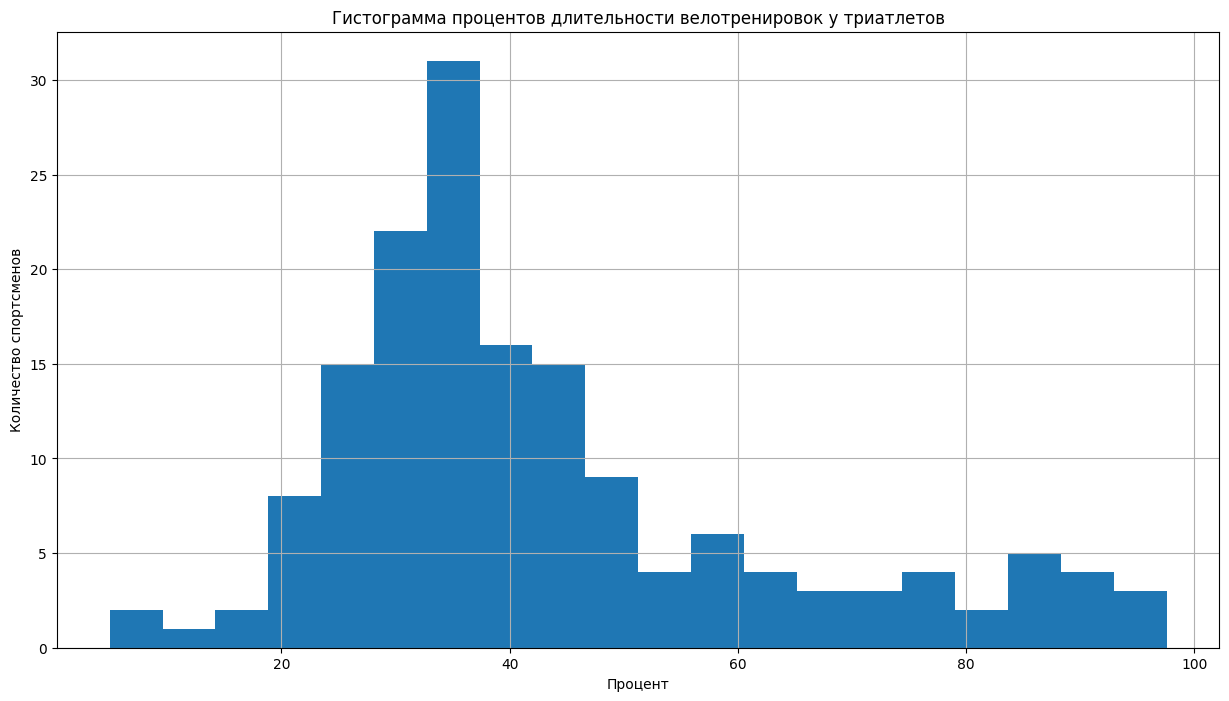

In [66]:
plt.figure(figsize=(15,8))

velo_plus['train_prob'].hist(bins = 20, alpha = 1, color = 'tab:blue', label = 'Триатлеты')
plt.title('Гистограмма процентов длительности велотренировок у триатлетов')
plt.ylabel('Количество спортсменов')
plt.xlabel('Процент')
#plt.legend()
plt.show()

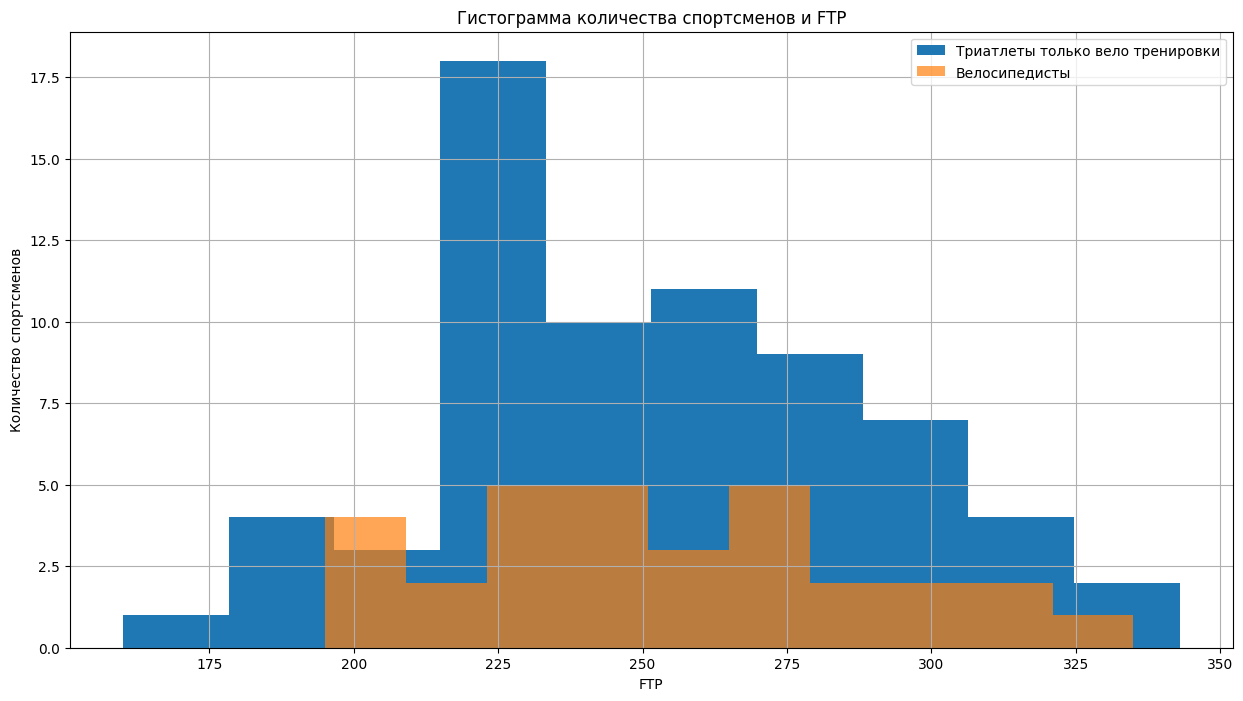

In [67]:
plt.figure(figsize=(15,8))

velo_plus.query('bike_minute > 200 & bike_minute < 400')['ftp_c'].hist(bins = 10, alpha = 1, color = 'tab:blue', label = 'Триатлеты только вело тренировки')
velo_only.query('bike_minute > 200 & bike_minute < 400')['ftp_c'].hist(bins = 10, alpha = 0.7,  color = 'tab:orange', label = 'Велосипедисты')
plt.title('Гистограмма количества спортсменов и FTP')
plt.ylabel('Количество спортсменов')
plt.xlabel('FTP')
plt.legend()
plt.show()

Проверим гипотезу, что при сопоставимом объеме только велотренировок у велоиспедистов и триатлетов, у первых будет выше FTP.

Вторая гипотеза: при сопоставимом FTP у велосипедистов и триатлетов у первых будет больше только велотренировок.

Третья гипотеза: при сопоставимом FTP у велосипедистов и триатлетов у последних общий объем всех тренировок будет больше, чем веломинут у велосипедистов

Проверку гипотез проведем только на спортсменах из середенной половины. Для этого возьмем границы из "золотой середины" статистических характетистик FTP и длительности тренировок

In [68]:
ftp_gold_min = train_stat.loc['FTP', '25%']
ftp_gold_max = train_stat.loc['FTP', '75%']
bikeminute_gold_min = train_stat.loc['Вело тренировки', '25%']
bikeminute_gold_max = train_stat.loc['Вело тренировки', '75%']
allminute_gold_min = velo_plus['all_minute'].describe().loc['25%']
allminute_gold_max = velo_plus['all_minute'].describe().loc['75%']

In [69]:
print(f"Границы серединной половины по FTP {ftp_gold_min} - {ftp_gold_max}")
print(f"Границы серединной половины по веломинутам {bikeminute_gold_min} - {bikeminute_gold_max}")
print(f"Границы серединной половины по минутам всех тренировок {allminute_gold_min} - {allminute_gold_max}")

Границы серединной половины по FTP 222.0 - 290.0
Границы серединной половины по веломинутам 180.0 - 414.0
Границы серединной половины по минутам всех тренировок 444.5 - 742.0


In [70]:
velo_compare = pd.DataFrame(columns = ('FTP', 'train_duration'))
velo_compare.loc['велосипедисты','FTP'] = round(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].mean(), 2)
velo_compare.loc['триатлеты только вело','FTP'] = round(velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].mean(), 2)
velo_compare.loc['триатлеты все тренировки','FTP'] = round(velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'].mean(), 2)


In [71]:
print(f"Средний FTP велосипедистов из золотой середины по длительности велотренировок - {velo_compare.loc['велосипедисты', 'FTP']} ватт")
print(f"Средний FTP триатлетов из золотой середины по длительности велотренировок - {velo_compare.loc['триатлеты только вело', 'FTP']} ватт")
print(f"Средний FTP триатлетов из золотой середины по длительности всех тренировок - {velo_compare.loc['триатлеты все тренировки', 'FTP']} ватт")

Средний FTP велосипедистов из золотой середины по длительности велотренировок - 251.81 ватт
Средний FTP триатлетов из золотой середины по длительности велотренировок - 250.1 ватт
Средний FTP триатлетов из золотой середины по длительности всех тренировок - 247.75 ватт


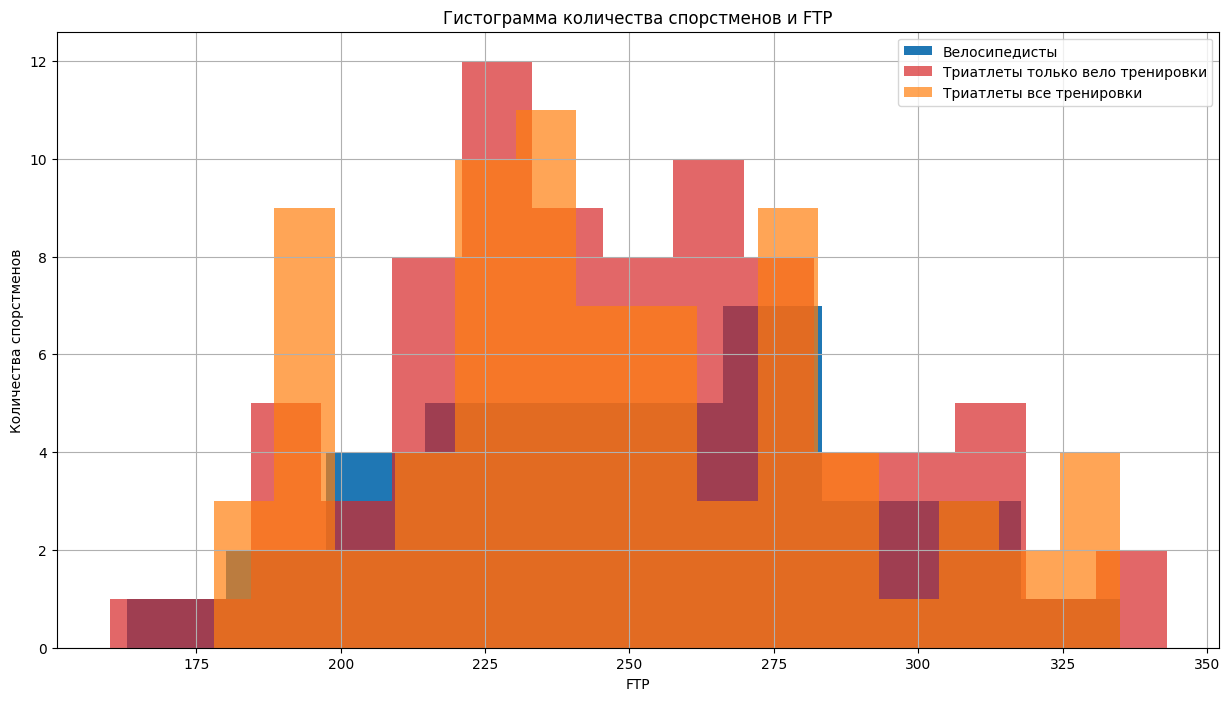

In [72]:
plt.figure(figsize=(15,8))

velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].hist(bins = 10, alpha = 1, color = 'tab:blue', label = 'Велосипедисты')
velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'].hist(bins = 15, alpha = 0.7, color = 'tab:red', label = 'Триатлеты только вело тренировки')
velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'].hist(bins = 15, alpha = 0.7,  color = 'tab:orange', label = 'Триатлеты все тренировки')
plt.title('Гистограмма количества спорстменов и FTP')
plt.ylabel('Количества спорстменов')
plt.xlabel('FTP')
plt.legend()
plt.show()

In [73]:
test_selection(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               velo_plus.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты, из "золотой середины" по веломинутам, имеют одинаковые FTP',
               h1 = 'У велосипедистов, из "золотой середины" по веломинутам, FTP больше',
               )

Первая выборка размером 36 прошла проверку на нормальное распределение. pval = 0.9750522694033779
Вторая выборка размером 81 прошла проверку на нормальное распределение. pval = 0.6468698315112222
Дисперсии выборок близки. pval = 0.8313758915763819. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!
Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 0.4126255643020532
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты, из "золотой середины" по веломинутам, имеют одинаковые FTP 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.3450316433652577
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты, из "золотой середины" по веломинутам, имеют одинаковые FTP 


In [74]:
test_selection(velo_only.query('bike_minute > @bikeminute_gold_min & bike_minute < @bikeminute_gold_max')['ftp_c'],
               velo_plus.query('all_minute > @allminute_gold_min & all_minute < @allminute_gold_max')['ftp_c'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты, из "золотой середины" по всем тренировкам, имеют одинаковые FTP',
               h1 = 'У велосипедистов, из "золотой середины" по всем тренировкам, FTP больше',
               )

Первая выборка размером 36 прошла проверку на нормальное распределение. pval = 0.9750522694033779
Вторая выборка размером 79 прошла проверку на нормальное распределение. pval = 0.23990788482648442
Дисперсии выборок близки. pval = 0.8654060585266823. Применяем equal_var=True 

Обе выборки имеют нормальное распределение!
Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 0.3059976750496031
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты, из "золотой середины" по всем тренировкам, имеют одинаковые FTP 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.2651885632081532
НЕ можем отвегнуть нулевую гипотезу, принимаем ее:
 ------>  Велосипедисты и триатлеты, из "золотой середины" по всем тренировкам, имеют одинаковые FTP 


То есть велосипедисты и триатлеты по показателю FTP как часовой максимальной мощности - сопоставимы / равны / одинаковы

In [75]:
velo_compare.loc['велосипедисты','train_duration'] = round(velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].mean(), 2)
velo_compare.loc['триатлеты только вело','train_duration'] = round(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].mean(), 2)
velo_compare.loc['триатлеты все тренировки','train_duration'] = round(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'].mean(), 2)

In [76]:
print(f"Средняя длительность велотренировок велосипедистов из золотой середины FTP - {velo_compare.loc['велосипедисты','train_duration']} минут")
print(f"Средняя длительность велотренировок триатлетов из золотой середины FTP - {velo_compare.loc['триатлеты только вело','train_duration']} минут")
print(f"Средняя длительность всех тренировок триатлетов из золотой середины FTP - {velo_compare.loc['триатлеты все тренировки','train_duration']} минут")

Средняя длительность велотренировок велосипедистов из золотой середины FTP - 359.69 минут
Средняя длительность велотренировок триатлетов из золотой середины FTP - 265.65 минут
Средняя длительность всех тренировок триатлетов из золотой середины FTP - 623.3 минут


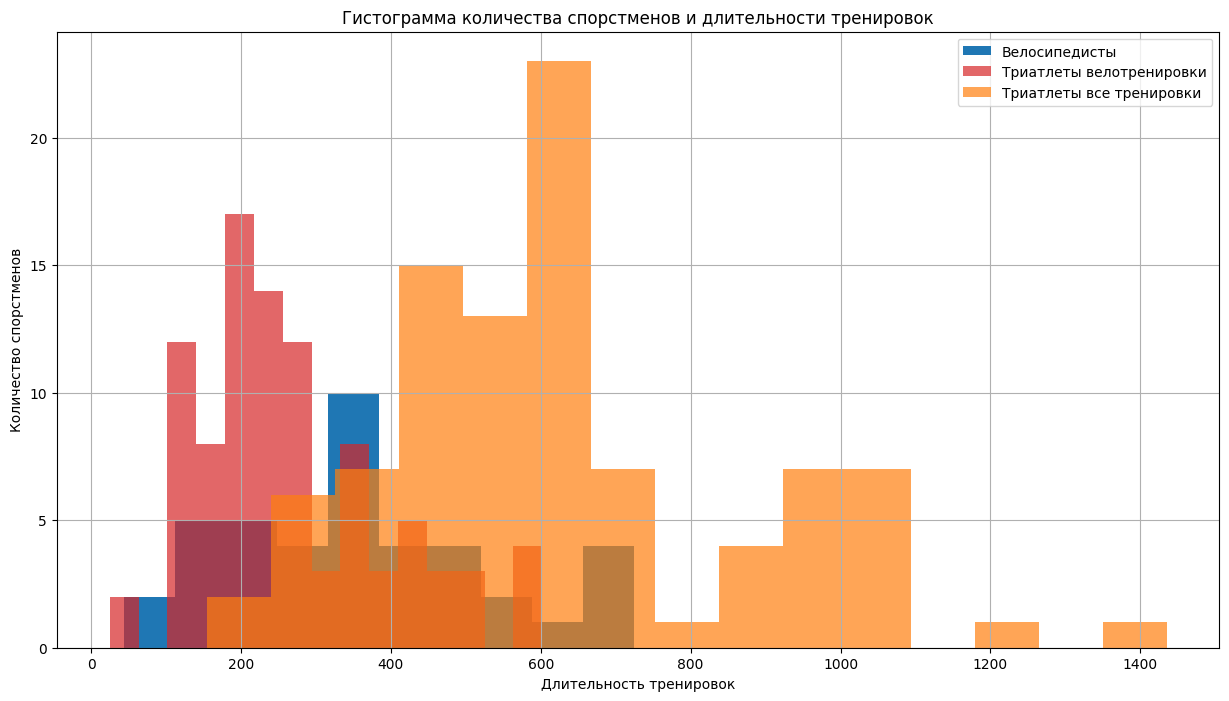

In [77]:
plt.figure(figsize=(15,8))

velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].hist(bins = 10, alpha = 1, color = 'tab:blue', label = 'Велосипедисты')
velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'].hist(bins = 15, alpha = 0.7, color = 'tab:red', label = 'Триатлеты велотренировки')
velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'].hist(bins = 15, alpha = 0.7,  color = 'tab:orange', label = 'Триатлеты все тренировки')
plt.title('Гистограмма количества спорстменов и длительности тренировок')
plt.ylabel('Количество спорстменов')
plt.xlabel('Длительность тренировок')
plt.legend()
plt.show()

In [78]:
test_selection(velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты, из "золотой середины" по FTP имеют, одинаковое количество веломинут',
               h1 = 'У велосипедистов, из "золотой середины" по FTP, веломинут больше, чем у триатлетов',
               )

Первая выборка размером 41 прошла проверку на нормальное распределение. pval = 0.48959484181929736
Вторая выборка размером 94 НЕ прошла проверку на нормальное распределение. pval = 0.003973829882853124
Дисперсии выборок НЕ близки. pval = 0.046671172013703806. Применяем equal_var=False

Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 0.0011518468433770412
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У велосипедистов, из "золотой середины" по FTP, веломинут больше, чем у триатлетов 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 0.0008059301632837491
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У велосипедистов, из "золотой середины" по FTP, веломинут больше, чем у триатлетов 


In [79]:
test_selection(velo_plus.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['all_minute'],
               velo_only.query('ftp_c >= @ftp_gold_min & ftp_c <= @ftp_gold_max')['bike_minute'],
               side='greater',
               h0 = 'Велосипедисты и триатлеты, из "золотой середины" по FTP, имеют одинаковую суммарную длительность всех тренировок',
               h1 = 'У триатлетов, из "золотой середины" по FTP, длительность всех тренировок больше',
               )

Первая выборка размером 94 НЕ прошла проверку на нормальное распределение. pval = 0.006910847975687906
Вторая выборка размером 41 прошла проверку на нормальное распределение. pval = 0.48959484181929736
Дисперсии выборок близки. pval = 0.06924674604107942. Применяем equal_var=True 

Выборки имеют размер > 30, то по Центральной предельной теореме, можно использовать ttest

--- Проводим TTest ---
В результате теста получено p-value 2.916252491054834e-09
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У триатлетов, из "золотой середины" по FTP, длительность всех тренировок больше 

Для сравнения проведем и параметрический тест Манна-Уитни

---- Проводим Test Mann-Whitneyu ----
В результате теста получено p-value 4.359028241297292e-09
НЕ можем принять нулевую гипотезу, принимаем альтернативную:
 ------>  У триатлетов, из "золотой середины" по FTP, длительность всех тренировок больше 


То есть у велосипедистов больше именно велотренировок, чем у триатлетов, но у триатлетов больше вообще тренировок, чем у велосипедистов. При этом FTP сопоставимы.


In [80]:
velo_compare.T

,велосипедисты,триатлеты только вело,триатлеты все тренировки
FTP,251.81,250.1,247.75
train_duration,359.69,265.65,623.3


In [81]:
print(f"У велосипедистов велотренировок больше, чем у триатлетов на {round(100 * (velo_compare.loc['велосипедисты', 'train_duration'] - velo_compare.loc['триатлеты только вело', 'train_duration']) / velo_compare.loc['триатлеты только вело', 'train_duration'], 2) } %")
print(f"У триатлетов всех тренировок больше, чем велотренировок у велосипедистов на {round(100 * (velo_compare.loc['триатлеты все тренировки', 'train_duration'] - velo_compare.loc['велосипедисты', 'train_duration']) / velo_compare.loc['велосипедисты', 'train_duration'], 2) } %")
print(f"При этому у велосипедистов FTP больше, чем у триатлетов на {round(100 * (velo_compare.loc['велосипедисты', 'FTP'] - velo_compare.loc['триатлеты все тренировки', 'FTP']) / velo_compare.loc['триатлеты все тренировки', 'FTP'], 2) } %")

У велосипедистов велотренировок больше, чем у триатлетов на 35.4 %
У триатлетов всех тренировок больше, чем велотренировок у велосипедистов на 73.29 %
При этому у велосипедистов FTP больше, чем у триатлетов на 1.64 %


Встает вопрос: это триатлеты более эффективно тренируются именно на вело, или триатлеты добирают в других видах тренировок?

# Сравнение способов определения FTP

FTP - это функциональная пороговая мощность или максимальная мощность, которую спортсмен способен проявить при езде на велосипеде в течение 60 минут. Это базовый показатель, на основе которого строятся тренировочные планы. Фактически он задает интенсивность тренровок, поэтму очень важно точно определить свое текущее FTP.

При этом существует несколько способов опредеения FTP. Само по себе такое разнообразие подразумевает определенные недостатки в каждом из них.

Поэтому стоит понимать, что в тренировочном процессе завышение FTP значительно хуже занижения. Так как занижениие грозит только тем, что спорстмен не достигнет уровня, который мог бы. А завышение FTP грозит уже непомерной наргузкой, перетренированностью и срывом выполнения всего тренировочного плана.

In [82]:
data['ftp_source_c'] = data['ftp_source'].apply(lambda x: 'Другое' if x not in (
    'По результатом полевых тестирований',
    'Из своих результатах на тренировках',
    'Расчетным путем исходя их результатов гонок',
    'Из результатов лабораторного тестирования',
    ) else x)

In [83]:
data['ftp_source_c'] = data['ftp_source_c'].str.replace('По результатом полевых тестирований', 'Поле')
data['ftp_source_c'] = data['ftp_source_c'].str.replace('Из своих результатах на тренировках', 'Тренировки')
data['ftp_source_c'] = data['ftp_source_c'].str.replace('Расчетным путем исходя их результатов гонок', 'Гонки')
data['ftp_source_c'] = data['ftp_source_c'].str.replace('Из результатов лабораторного тестирования', 'Лаборатория')

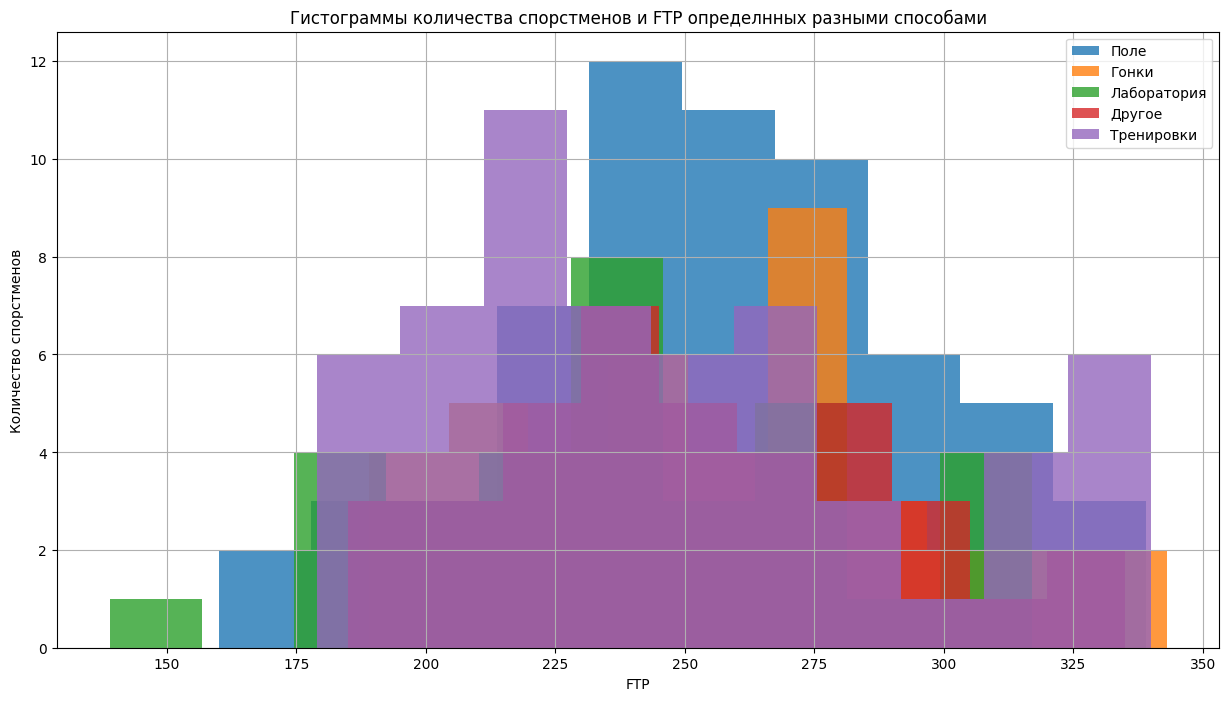

In [84]:
plt.figure(figsize=(15,8))

for ftp_souce in data['ftp_source_c'].unique():
  data.query('ftp_source_c == @ftp_souce')['ftp_c'].hist(bins = 10, alpha = 0.8, label = ftp_souce)

plt.title('Гистограммы количества спорстменов и FTP определнных разными способами')
plt.ylabel('Количество спорстменов')
plt.xlabel('FTP')
plt.legend()
plt.show()

In [85]:
ftp_souce_type = data['ftp_source_c'].unique()
ftp_sourcep_data = dict()
for ftp_source_x in ftp_souce_type:
    ftp_sourcep_data[ftp_source_x] = data.query('ftp_source_c == @ftp_source_x')['ftp_c']
    print(f"{len(ftp_sourcep_data[ftp_source_x])} спорстменов определили свой FTP {ftp_source_x}. Среднее значсение FTP {ftp_sourcep_data[ftp_source_x].median()}")

62 спорстменов определили свой FTP Поле. Среднее значсение FTP 259.0
41 спорстменов определили свой FTP Гонки. Среднее значсение FTP 260.0
33 спорстменов определили свой FTP Лаборатория. Среднее значсение FTP 235.0
38 спорстменов определили свой FTP Другое. Среднее значсение FTP 249.5
58 спорстменов определили свой FTP Тренировки. Среднее значсение FTP 236.5


Проверка на нормальное распределение. В ячейцках значения p-value для распределени способа определения FTP.
Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка нормального распредения НЕ пройдена.

In [86]:
ftp_sourcep_norm = pd.DataFrame([])
for ftp_source_x in ftp_souce_type:
    pval = stats.normaltest(ftp_sourcep_data[ftp_source_x])[1]
    ftp_sourcep_norm.loc['norm', ftp_source_x] = pval
ftp_sourcep_norm.style.apply(highlight_stat, color='tomato')

,Поле,Гонки,Лаборатория,Другое,Тренировки
norm,0.769881,0.549443,0.987090,0.700315,0.063745


Проверка на равенства дисперсий. В ячейцках значения p-value для попарного сравнения дисперсий выборок. Подкрашивается ячейка, в которой значение p-value < 0.05, то есть проверка равенства дисперсий НЕ пройдена.

In [87]:
ftp_souce_leneve = pd.DataFrame([])
for ftp_source_x in ftp_souce_type:
  for ftp_source_y in ftp_souce_type:

        pval = stats.levene(ftp_sourcep_data[ftp_source_x], ftp_sourcep_data[ftp_source_y])[1]

        ftp_souce_leneve.loc[ftp_source_x, ftp_source_y] = pval
ftp_souce_leneve.style.apply(highlight_stat, color='tomato')

,Поле,Гонки,Лаборатория,Другое,Тренировки
Поле,1.000000,0.857492,0.892831,0.601411,0.250354
Гонки,0.857492,1.000000,0.982567,0.503188,0.380882
Лаборатория,0.892831,0.982567,1.000000,0.574340,0.427565
Другое,0.601411,0.503188,0.574340,1.000000,0.141801
Тренировки,0.250354,0.380882,0.427565,0.141801,1.000000


По парное сравнение выборок FTP, определенного разными способами. В ячейках - p-value нулевой гипозеты, что FTP сопоставимые, альтернативная гипотеза - что FTP, определенное способом по горизонтали больше, чем способом по вертикали.
Подкрашены ячейки, в которых p-value < 0.05 - то есть где нулевая гипотеза отвергается и принимается альтернативная.

Попарная проверка гипотезы, что один из способов опредедления FTP завышает. Если завышает - подкраситься красным.

In [88]:
ftp_source_table = pd.DataFrame([])
for ftp_source_x in ftp_souce_type:
  for ftp_source_y in ftp_souce_type:
    ftp_source_table.loc[ftp_source_x, ftp_source_y] = stats.ttest_ind(ftp_sourcep_data[ftp_source_x], ftp_sourcep_data[ftp_source_y], alternative = 'greater', equal_var='True')[1]
ftp_source_table.style.apply(highlight_stat)

,Поле,Гонки,Лаборатория,Другое,Тренировки
Поле,0.500000,0.507182,0.027423,0.289275,0.133029
Гонки,0.492818,0.500000,0.037813,0.297954,0.158708
Лаборатория,0.972577,0.962187,0.500000,0.908961,0.803546
Другое,0.710725,0.702046,0.091039,0.500000,0.314518
Тренировки,0.866971,0.841292,0.196454,0.685482,0.500000


Определение FTP результате полевых тестирований и расчетов, исходя их гонок, обнаруживют статистически значимое превышение результатов при тестировании в лаборатории.

Стоит отметить, что FTP на основе других способой определения FTP - тесты в Zwift, показания Garmin и метрики intervals.icu - весьма близки к критическому p-value в 0,05, который определеяет статистическую значимость различий.

В связи с этим интересно посмотреть, каким способом спорстмены определяют FTP в зависимости от стажа

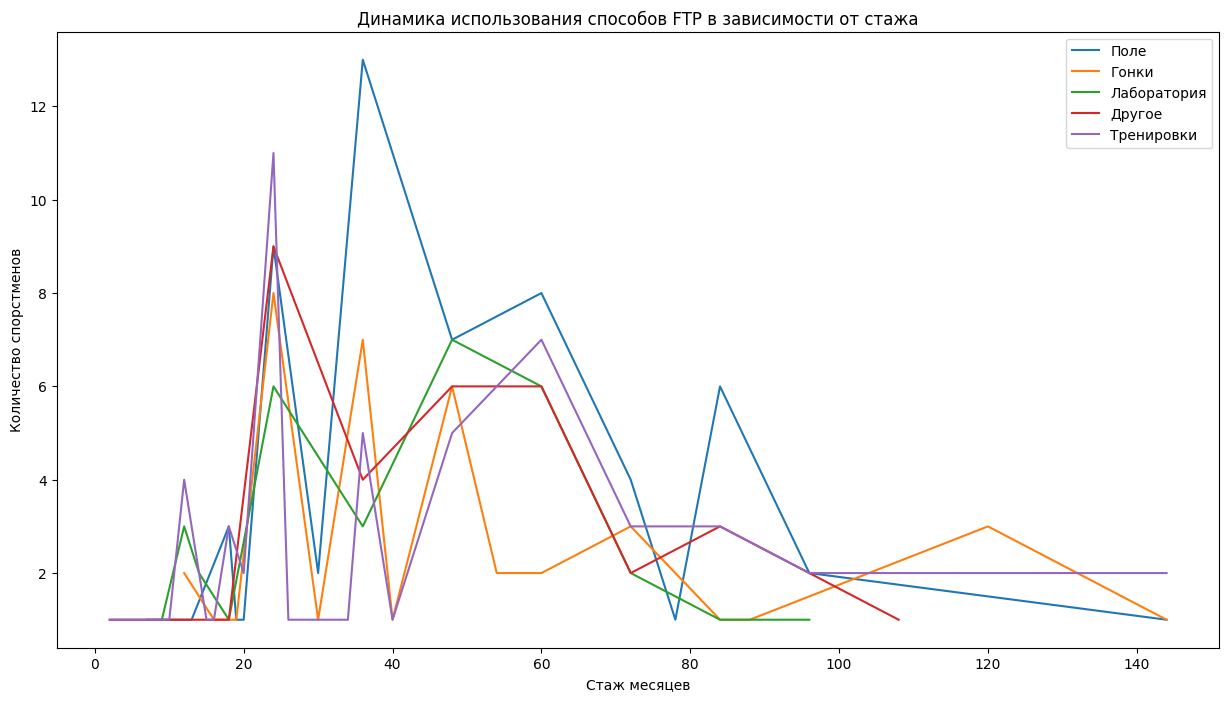

In [89]:
plt.figure(figsize=(15,8))
for ftp_s in data['ftp_source_c'].unique():
  dd = data.query('ftp_source_c == @ftp_s').groupby('stag_r')['ftp_source_c'].count()
  plt.plot(dd,  label = ftp_s)
plt.legend()
plt.title('Динамика использования способов FTP в зависимости от стажа')
plt.xlabel('Стаж месяцев')
plt.ylabel('Количество спорстменов')
plt.show()

In [90]:
qstr_last = ''
ftp_source = dict()
for i in range(18, 100, 12):
    qstr = qstr_last + 'stag_r <= ' + str(i)
    #print(qstr)
    ftp_source[i] = data.query(qstr).groupby('ftp_source_c')['date_answer'].count()
    qstr_last =  str(i) + ' < '
ftp_source[999] = data.query(qstr).groupby('ftp_source_c')['date_answer'].count()

Доли использования различных способов определения FTP по когортам стажа


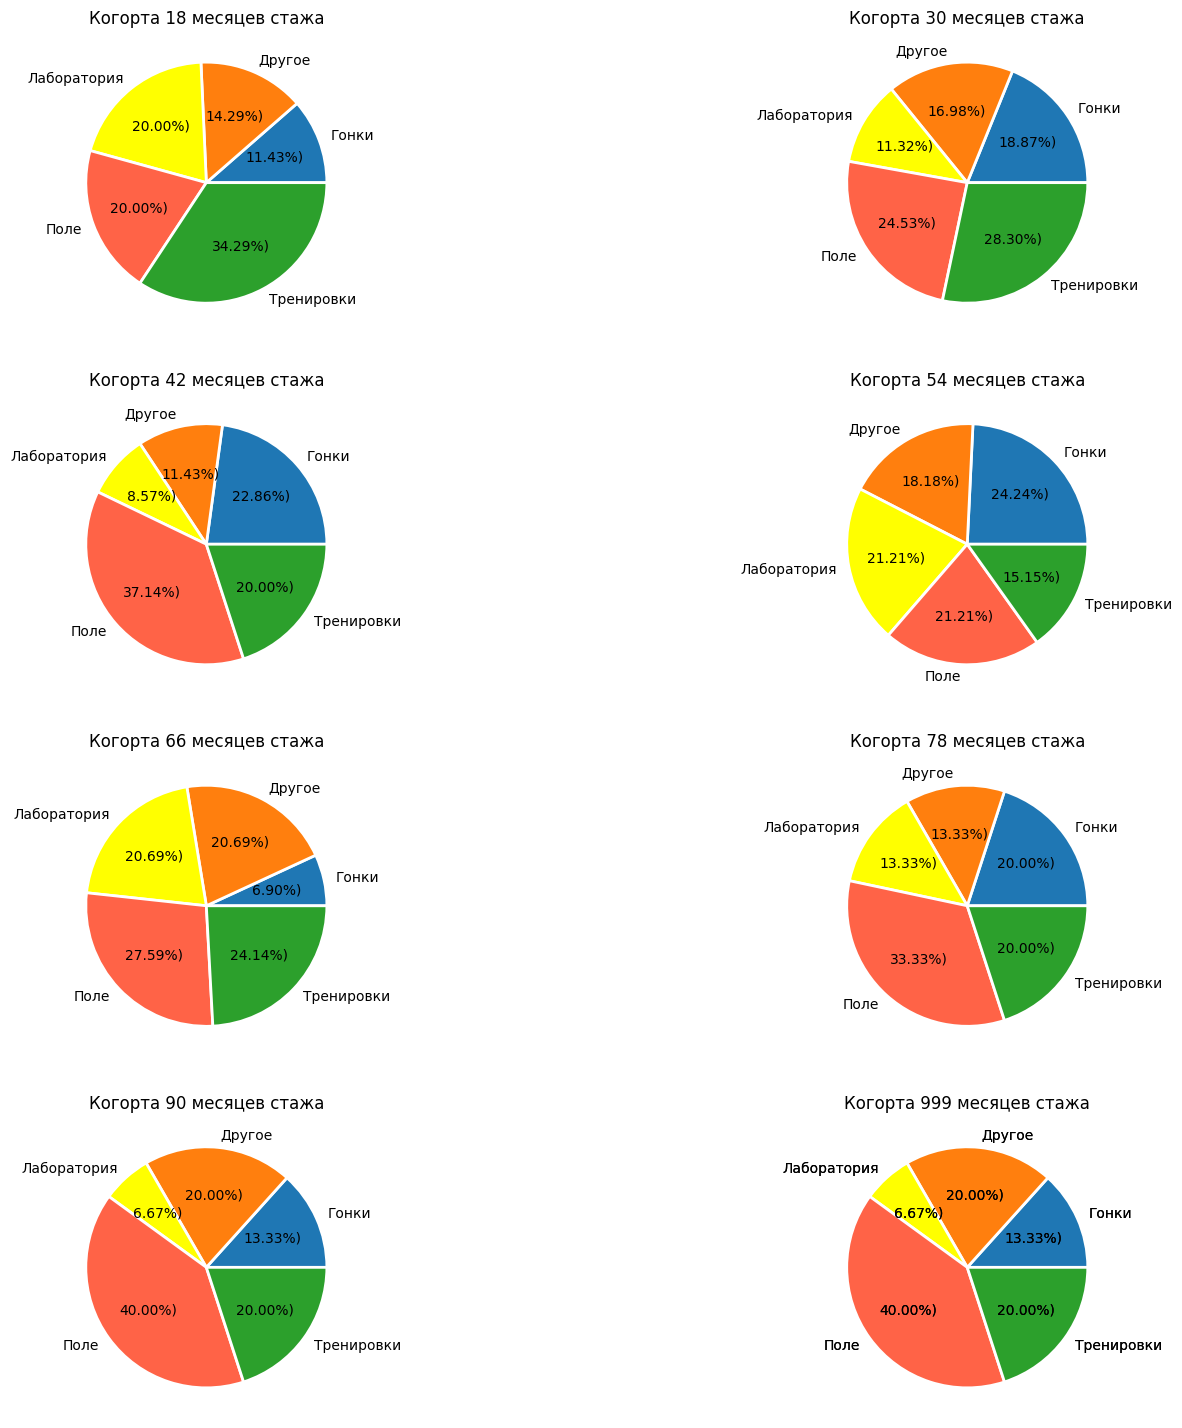

In [91]:
f, ax = plt.subplots(4, 2, figsize=(18,18))
x = y = i = 0

for s in ftp_source:
  ax[y, x].pie(x = ftp_source[s], labels = ftp_source[s].index, colors = ['tab:blue', 'tab:orange', 'yellow', 'tomato', 'tab:green'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
  ax[y, x].set_title(f'Когорта {s} месяцев стажа')
  x +=1
  if x >= 2:
    x = 0
    y += 1
ax[3, 1].pie(x = ftp_source[999], labels = ftp_source[999].index, colors = ['tab:blue', 'tab:orange', 'yellow', 'tomato', 'tab:green'],
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, autopct=lambda p : '{:.2f}%)'.format(p))
ax[3, 1].set_title(f'Когорта {999} месяцев стажа')
plt.show()

# Выводы

Между FTP и длительностью велотренировок у велосипедистов и триатлетов в целом обнаруживается средняя положительная корреляция. Спортсмены, которые тренируются в неделю на один час больше, имеют и FTP в среднем на 6-7 ватт больше.

Когортный анализ таже показывает связь роста веломинут и FTP. А вот связи со тренировочным стажем - не обнаруживается. Кроме этого анализе когорт обнаружилось, что связь FTP и длительности тренировок - не монотонная. На нее как бы накладывается некая волновая функция. Природу этого эффекта выяснить не удалось. Возможно, это просто методическая ошибка.

Сравнение тренировок велосипедистов и триатлетов показало, что триатлеты имеют, можно сказать, такие же мощности как и велосипедисты. Но при этом длительность велотренировок велосипедистов на 35% большее. Скорее всего, триатлеты дорабатывают свою форму тренировкиам еще и по других видам спорта. С учетом всех тренировок, перевес в длительности уже у триатлетов, более чем в полтора раза.

Сравнение способов определения FTP показало завышение показателя относительно лабораторных тестов в "полевых" тестах и при расчетах на основе гонок. При этом важность адекватного определения FTP влияет на эффетивность тренировок, так как они строятся во многом на основе этого параметра.